In [1]:
import os
import json
import re
import math
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from skimage.io import imread, imsave
from skimage.transform import warp
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter, find_peaks
import scipy.stats as stats
from scipy.integrate import odeint, solve_ivp
from numba import njit, prange
from skimage.filters import gaussian
from scipy.ndimage import uniform_filter1d
from numpy.polynomial import Polynomial

In [10]:
#path_ext = '/media/c1046372/Expansion/Thesis GY/3. Analyzed files'
path_ext = '/media/guillermo/Expansion/Thesis GY/3. Analyzed files'

In [3]:
def plot_dlrho(dlkymo_rho, edt, rs, pos, fluo_chns,t0):
    wdlkymo_rho = np.zeros_like(dlkymo_rho)
    nt, _ = dlkymo_rho.shape
    
    if fluo_chns == 3:
        for c in range(fluo_chns-1):
            wdlkymo_rho[:,:,c] = warp(dlkymo_rho[:,:,c], map_edt, {'edt':edt, 'rs':rs})
        wdlkymo_rho[np.isnan(dlkymo_rho)] = np.nan
        
        plt.figure(figsize=(7,2))
        plt.subplot(1, 2, 1)
        plt.imshow(np.hstack([wdlkymo_rho[t0:,::-1,0],wdlkymo_rho[t0:,:,0]]).transpose(), 
                aspect='auto', 
                extent=[t0,nt,-edt.max(),edt.max()],
                vmin=-0.1, vmax=0.1,
                cmap='jet')
        plt.colorbar()
        plt.xlabel('Time (frames)')
        plt.ylabel('Radial distance (pixels)')
        plt.title('$d\mathrm{log}\\rho_{rc}/dt$')
        
        plt.subplot(1, 2, 2)
        plt.imshow(np.hstack([wdlkymo_rho[t0:,::-1,1],wdlkymo_rho[t0:,:,1]]).transpose(), 
                aspect='auto', 
                extent=[t0,nt,-edt.max(),edt.max()],
                vmin=-0.1, vmax=0.1,
                cmap='jet')
        plt.colorbar()
        plt.xlabel('Time (frames)')
        plt.ylabel('Radial distance (pixels)')
        plt.title('$d\mathrm{log}\\rho_{yc}/dt$')
        
        plt.tight_layout()
        #plt.savefig(path_save, dpi=300)

    else:
        wdlkymo_rho[:,:] = warp(dlkymo_rho[:,:], map_edt, {'edt':edt, 'rs':rs})
        wdlkymo_rho[np.isnan(dlkymo_rho)] = np.nan
        
        plt.figure(figsize=(7,2))
        #plt.subplot(1, 2, 1)
        plt.imshow(np.hstack([wdlkymo_rho[t0:,::-1],wdlkymo_rho[t0:,:]]).transpose(), 
                aspect='auto', 
                extent=[t0,nt,-edt.max(),edt.max()],
                vmin=-0.1, vmax=0.1,
                cmap='jet')
        plt.colorbar()
        plt.xlabel('Time (frames)')
        plt.ylabel('Radial distance (pixels)')
        plt.title('$d\mathrm{log}\\rho_{yc}/dt$')
        plt.tight_layout()
        #plt.savefig(path_save, dpi=300)

In [4]:
def map_edt(p, edt, rs):
    rstep = np.mean(np.diff(rs))
    npos = p.shape[0]
    for i in range(npos):
        r,t = p[i,:].astype(int)
        # transformation from distance from the center
        p[i,0] = (edt[t,:,:].max() - rs[r]) / rstep
    return p

In [5]:
#scope_name = 'Tweez scope'

#path_scope = os.path.join(path_ext, scope_name)
#path = os.path.join(path_scope, exp_date)
folder_masks = 'contour_masks'
folder_results = 'results'
folder_fluo = 'fluo'
folder_graphs = 'graphs'
folder_velocity = 'velocity_data'
vectors = ['pAAA', 'pLPT20&41', 'pLPT107&41', 'pLPT119&41']
channels = {'pAAA': {'rfp':0,'yfp':1,'cfp':2,'phase':3},
            'pLPT20&41': {'yfp':0,'cfp':1,'phase':2}, 
            'pLPT119&41': {'yfp':0,'cfp':1,'phase':2},
            'pLPT107&41': {'rfp':0,'yfp':1,'cfp':2,'phase':3}}
scopes = {'Tweez scope': 'TiTweez', 'Ti scope': 'Ti'}
dnas = {'pLPT20&pLPT41': 'pLPT20&41', 'pLPT119&pLPT41': 'pLPT119&41', 'pAAA': 'pAAA', 'pLPT107&pLPT41': 'pLPT107&41'}


In [6]:
#exp_date = '2023_11_15'
#scope_name = 'Ti scope'
#vector = 'pLPT20&pLPT41'

In [7]:
if vector == 'pLPT20&pLPT41' or vector == 'pLPT119&pLPT41':
    yfp_chn = 0
    cfp_chn = 1
    ph_chn = 2
    fluo_chns = 2
else:
    rfp_chn = 0
    yfp_chn = 1
    cfp_chn = 2
    ph_chn = 3
    fluo_chns = 3

In [6]:
exp_sum = pd.read_excel('../Notebooks/Exps_summary.xlsx')
exp_sum['formatted_dates'] = exp_sum['Date'].dt.strftime('%Y_%m_%d')
positions = pd.read_excel('../Notebooks/Positions.xlsx')
exp_sum

Date      Machine           Strain             DNA Chemical Dilution  \
0  2023-11-15     Ti scope  MC4100 & DHL708   pLPT20&pLPT41        -  10^(-5)   
1  2023-11-15  Tweez scope  MC4100 & DHL708   pLPT20&pLPT41        -  10^(-6)   
2  2023-11-17     Ti scope           DHL708  pLPT119&pLPT41        -  10^(-5)   
3  2023-11-17  Tweez scope  MC4100 & DHL708  pLPT119&pLPT41        -  10^(-6)   
4  2023-11-28     Ti scope  MC4100 & MG1655            pAAA        -  10^(-6)   
5  2023-11-28  Tweez scope           MG1655            pAAA        -  10^(-5)   
6  2023-11-30     Ti scope           MC4100            pAAA        -  10^(-6)   
7  2023-11-30  Tweez scope           MC4100            pAAA        -  10^(-5)   
8  2023-12-04     Ti scope           MC4100  pLPT107&pLPT41     IPTG  10^(-6)   
9  2023-12-04  Tweez scope           MC4100  pLPT107&pLPT41     IPTG  10^(-5)   
10 2023-12-06  Tweez scope           MC4100   pLPT20&pLPT41     IPTG  10^(-5)   
11 2023-12-08     Ti scope           MC4100  pLPT107&pLPT41      aTc  10^(-5)   
12 2023-12-08  Tweez scope           MC4100   pLPT20&pLPT41      aTc  10^(-5)   

   formatted_dates  
0       2023_11_15  
1       2023_11_15  
2       2023_11_17  
3       2023_11_17  
4       2023_11_28  
5       2023_11_28  
6       2023_11_30  
7       2023_11_30  
8       2023_12_04  
9       2023_12_04  
10      2023_12_06  
11      2023_12_08  
12      2023_12_08

In [9]:
i = 0

In [174]:
#for i in exp_sum.index.values:
#exp_date = exp_sum.loc[i,'formatted_dates']
#vector = exp_sum.loc[i,'DNA']
#scope_name = exp_sum.loc[i,'Machine']
"""
df_pos = positions[(positions.Date == exp_sum.loc[i, 'Date']) & 
    (positions.DNA == vector) & 
    (positions.Machine == scope_name) & 
    (positions.Quality == 'Very good')]
poss = df_pos.Position.unique()
poss
"""

"\ndf_pos = positions[(positions.Date == exp_sum.loc[i, 'Date']) & \n    (positions.DNA == vector) & \n    (positions.Machine == scope_name) & \n    (positions.Quality == 'Very good')]\nposs = df_pos.Position.unique()\nposs\n"

In [933]:
df = pd.read_excel('../Notebooks/data_processed.xlsx')
for i in [0]:#exp_sum.index.values:
    exp_date = exp_sum.loc[i,'formatted_dates']
    vector = exp_sum.loc[i,'DNA']
    scope_name = exp_sum.loc[i,'Machine']
    df_pos = positions[(positions.Date == exp_sum.loc[i, 'Date']) & 
        (positions.DNA == vector) & 
        (positions.Machine == scope_name) & 
        (positions.Quality == 'Very good')]
    poss = df_pos.Position.unique()
    if vector == 'pLPT20&pLPT41' or vector == 'pLPT119&pLPT41':
        yfp_chn = 0
        cfp_chn = 1
        ph_chn = 2
        fluo_chns = 2
    else:
        rfp_chn = 0
        yfp_chn = 1
        cfp_chn = 2
        ph_chn = 3
        fluo_chns = 3
    
    for pos in [0]:#poss:
        print(f"Pos {pos}")
        print(f"{exp_date}_{scopes[scope_name]}_{vector}")
        path_scope = os.path.join(path_ext, scope_name)
        path = os.path.join(path_scope, exp_date)
        path_results = os.path.join(path, folder_results, f"pos{pos}")
        df_idx = df[(df['Date'].dt.strftime('%Y_%m_%d') == exp_date) & 
            (df.Machine == scope_name) & 
            (df.Position == pos)].index[0]

Pos 0
2023_11_15_Ti_pLPT20&pLPT41


In [934]:
df_idx

0

In [939]:
t0

10

In [940]:
tf

42

Pos 38
2023_12_08_TiTweez_pLPT20&pLPT41
t0: 82, tf: 124


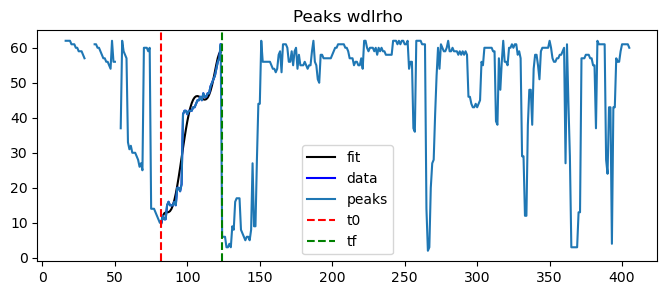

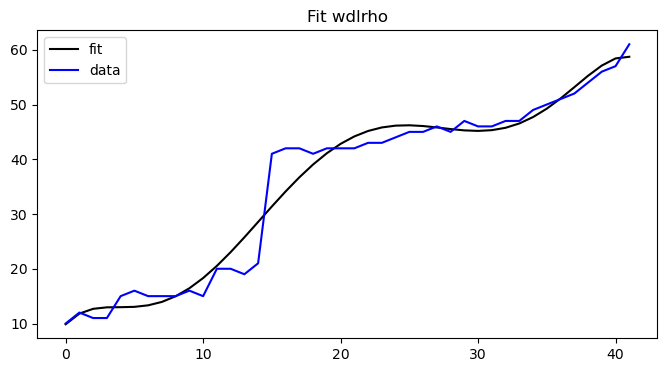

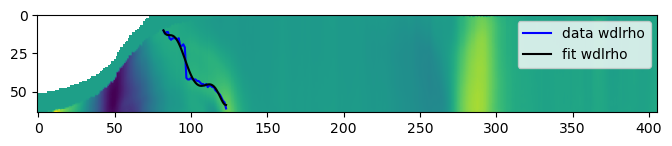

In [895]:
#pdf_file = PdfPages('output_plots.pdf')
#pdf_path = 'output_plots.pdf'
df = pd.read_excel('../Notebooks/data_processed.xlsx')
for i in [12]:#exp_sum.index.values:
    exp_date = exp_sum.loc[i,'formatted_dates']
    vector = exp_sum.loc[i,'DNA']
    scope_name = exp_sum.loc[i,'Machine']
    df_pos = positions[(positions.Date == exp_sum.loc[i, 'Date']) & 
        (positions.DNA == vector) & 
        (positions.Machine == scope_name) & 
        (positions.Quality == 'Very good')]
    poss = df_pos.Position.unique()
    if vector == 'pLPT20&pLPT41' or vector == 'pLPT119&pLPT41':
        yfp_chn = 0
        cfp_chn = 1
        ph_chn = 2
        fluo_chns = 2
    else:
        rfp_chn = 0
        yfp_chn = 1
        cfp_chn = 2
        ph_chn = 3
        fluo_chns = 3
    
    for pos in [38]:#poss:
        print(f"Pos {pos}")
        print(f"{exp_date}_{scopes[scope_name]}_{vector}")
        path_scope = os.path.join(path_ext, scope_name)
        path = os.path.join(path_scope, exp_date)
        path_results = os.path.join(path, folder_results, f"pos{pos}")
        df_idx = df[(df['Date'].dt.strftime('%Y_%m_%d') == exp_date) & 
            (df.Machine == scope_name) & 
            (df.Position == pos)].index[0]
        delta_idx = 0
        if pd.notna(df.loc[df_idx, 'time_wave_start_guess']):
            t0 = int(df.loc[df_idx, 'time_wave_start_guess'])
            tf = int(df.loc[df_idx, 'time_wave_arrival_guess'])
            print(f"t0: {t0}, tf: {tf}")

            ## Peaks wdlrho
            wdlkymo_rho = np.load(os.path.join(path_results,'wdlkymo_rho.npy'))
            nt, nr, _ = wdlkymo_rho.shape
            data = wdlkymo_rho[:,::-1,delta_idx].transpose()            
            rads = np.zeros(nt)
            for t in range(nt):
                peaks, _ = find_peaks(data[:,t])
                try:
                    idx = np.argsort(data[peaks,t])[-1]
                    rads[t] = peaks[idx]
                except:
                    rads[t] = np.nan
    
            degree = 6

            #rads_or = rads
            #rads = savgol_filter(rads, 21,3)

            ## Fit wdlkymo
            wave_pos_coefs = np.polyfit(np.arange(len(rads[t0:tf])), rads[t0:tf], degree)
            wave_pos_fit = np.polyval(wave_pos_coefs, np.arange(len(rads[t0:tf])))
            #wave_pos_fit = np.polyval(wave_pos_coefs, np.arange(len(rads[t0:tf])+5))
            
            wave_vel_coefs = np.polyder(wave_pos_coefs)
            wave_vel_fit = np.polyval(wave_vel_coefs, np.arange(len(rads[t0:tf])))
            #with PdfPages(pdf_path) as pdf_file:

            ## peaks wdlrho
            plt.figure(figsize=(8,3))
            plt.plot(np.arange(t0,t0+len(rads[t0:tf])),wave_pos_fit, color='k',label='fit')
            plt.plot(np.arange(t0,t0+len(rads[t0:tf])), rads[t0:tf], color='b', label='data')
            plt.plot(rads, label='peaks')
            plt.axvline(x=t0, color='r', linestyle='--', label='t0')
            plt.axvline(x=tf, color='g', linestyle='--', label='tf')
            plt.title('Peaks wdlrho')
            plt.legend()
            #pdf_file.savefig() 
            #plt.close()
            plt.show()

            ## fit wdlrho
            plt.figure(figsize=(8,4))
            plt.plot(np.arange(len(rads[t0:tf])),wave_pos_fit, color='k',label='fit')
            plt.plot(np.arange(len(rads[t0:tf])), rads[t0:tf], color='b', label='data')
            plt.title('Fit wdlrho')
            plt.legend()
            #pdf_file.savefig() 
            #plt.close()
            plt.show()
            
            plt.figure(figsize=(8,4))            
            plt.imshow(data)
            plt.plot(np.arange(t0,tf), rads[t0:tf], color='b', label='data wdlrho')
            plt.plot(np.arange(t0,tf),wave_pos_fit, color='k',label='fit wdlrho')
            plt.legend()
            plt.legend()
            #plt.colorbar()
            #pdf_file.savefig() 
            #plt.close()
            plt.show()


(398, 64, 3)

Pos 0
2023_12_04_Ti_pLPT107&pLPT41
t0: 40, tf: 215


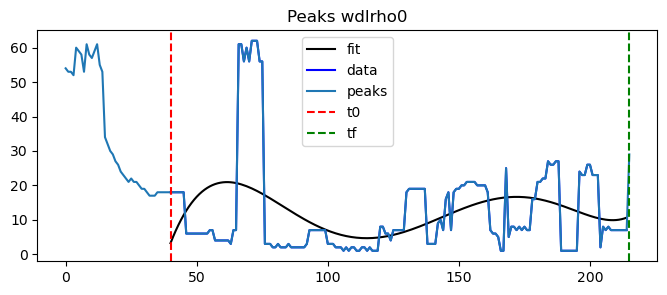

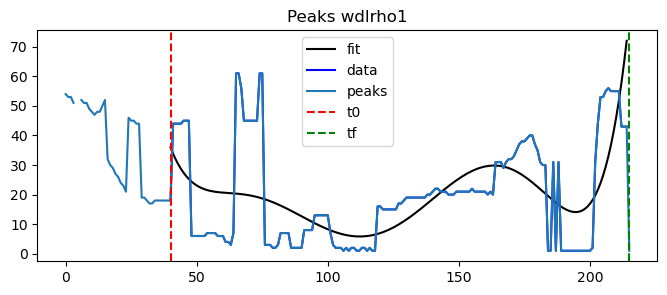

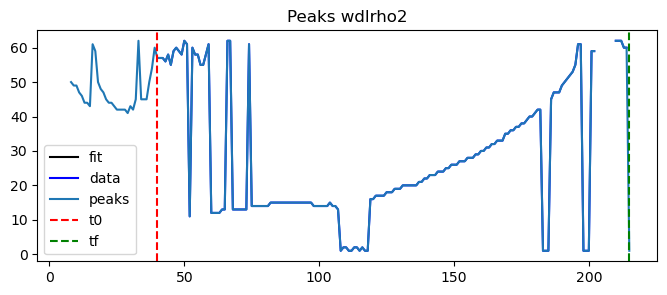

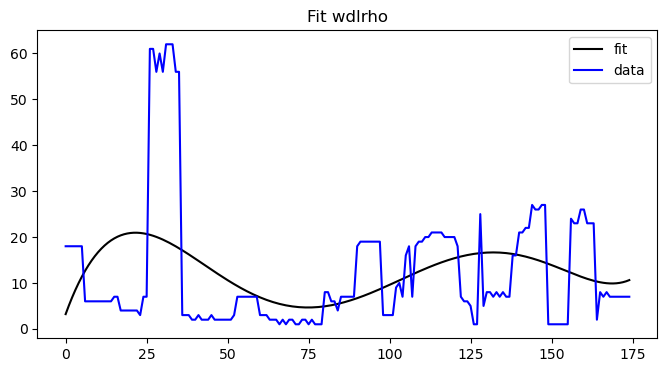

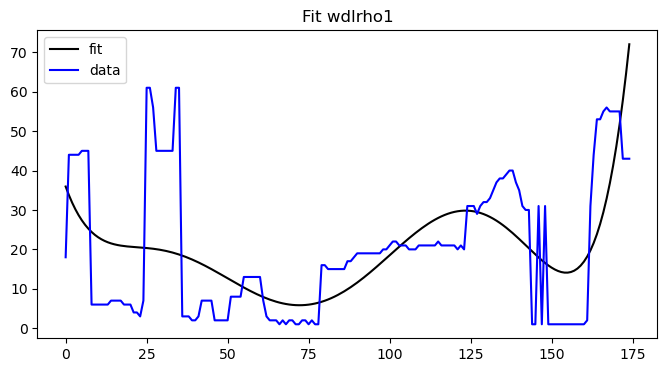

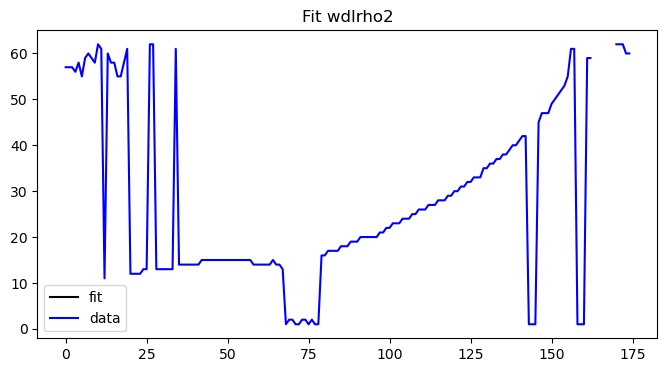

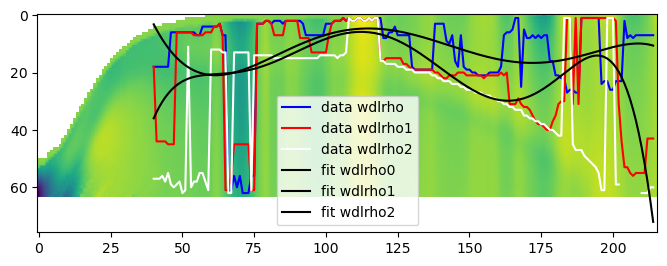

Pos 2
2023_12_04_Ti_pLPT107&pLPT41
t0: 40, tf: 215


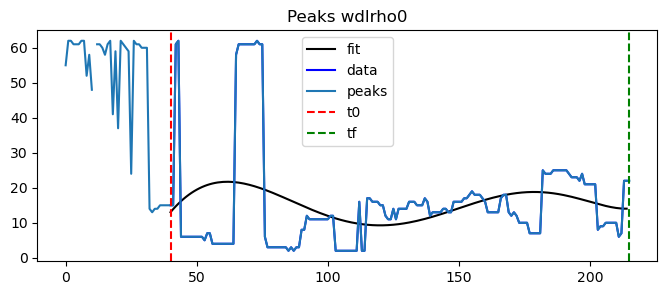

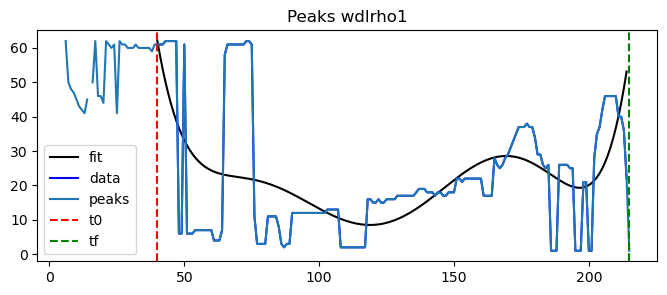

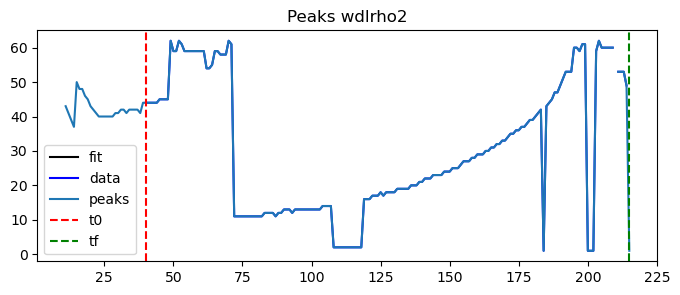

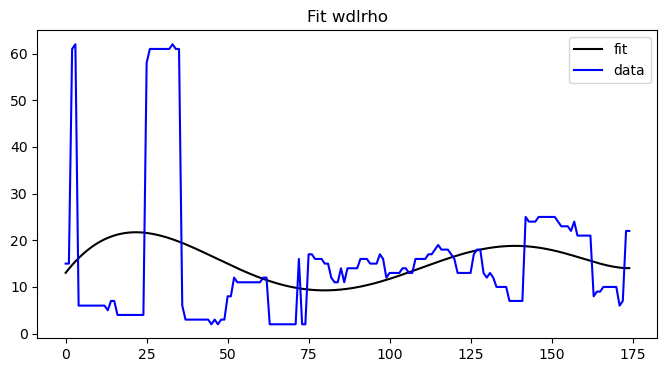

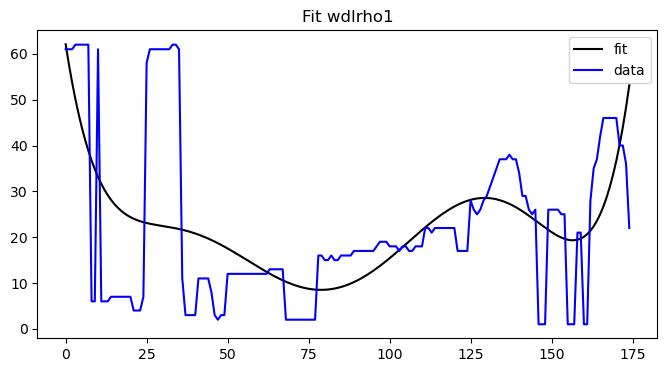

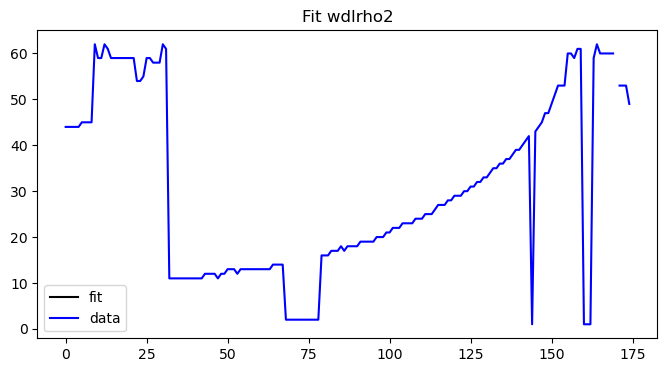

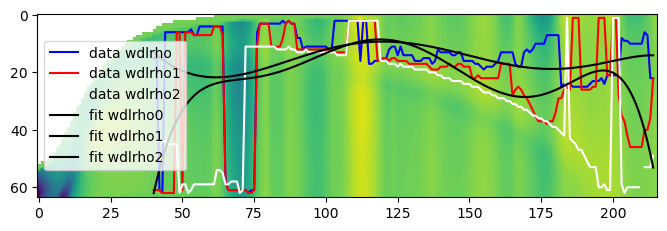

Pos 3
2023_12_04_Ti_pLPT107&pLPT41
t0: 40, tf: 215


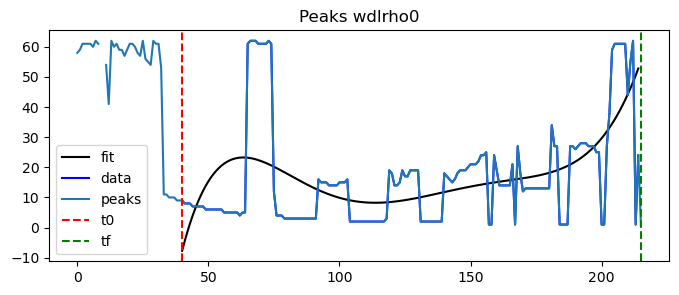

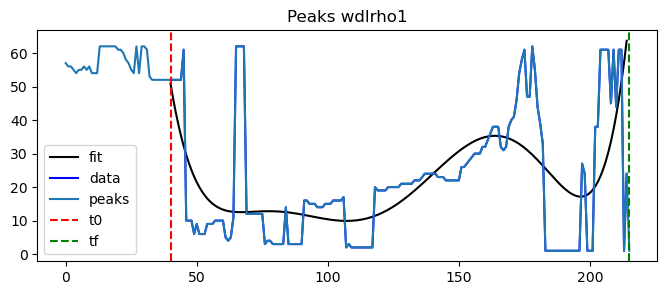

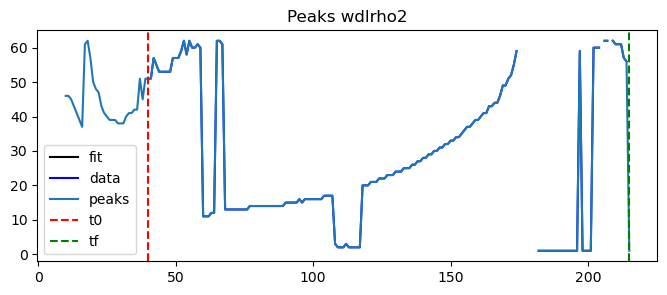

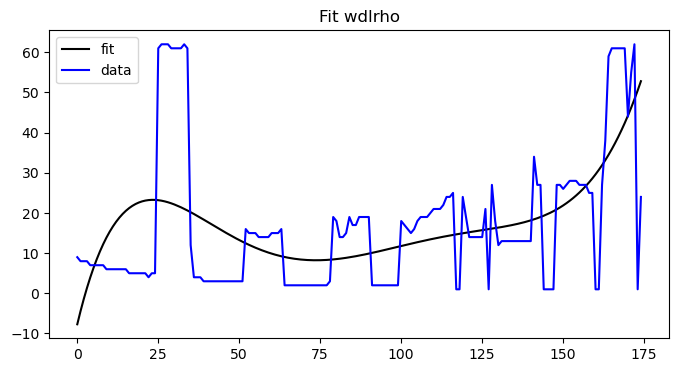

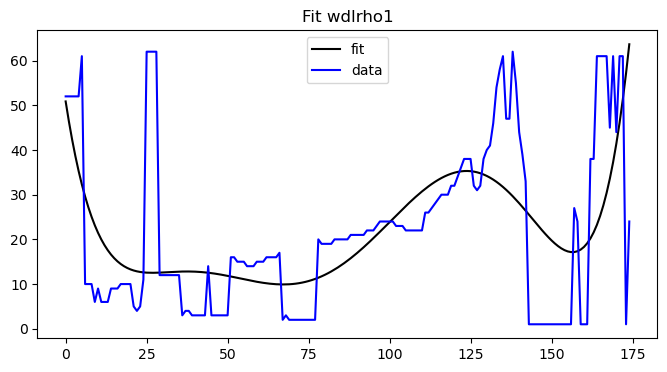

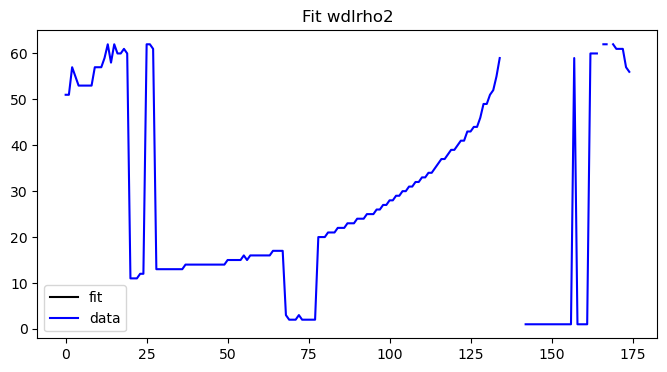

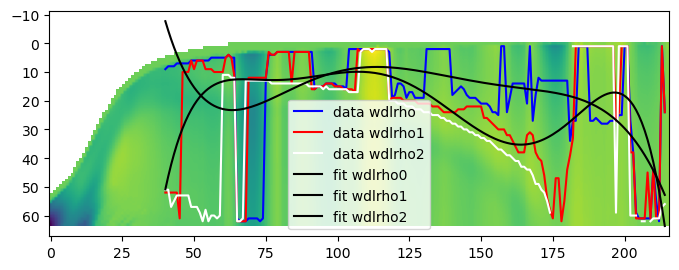

Pos 9
2023_12_04_Ti_pLPT107&pLPT41
t0: 40, tf: 215


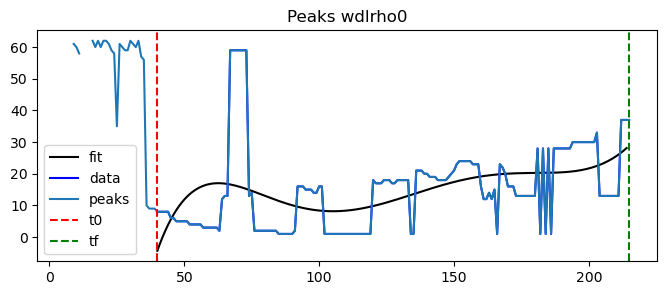

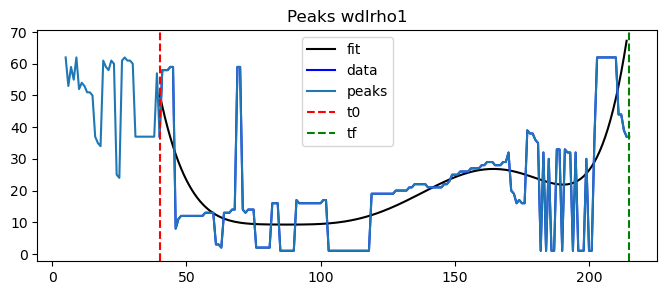

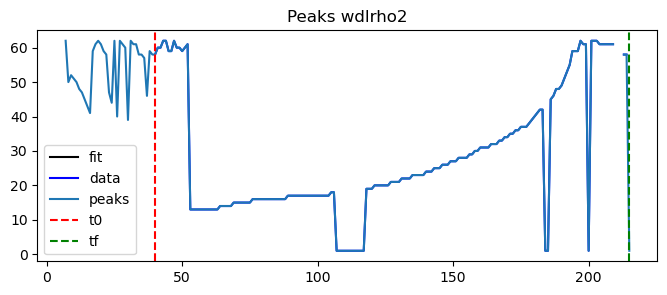

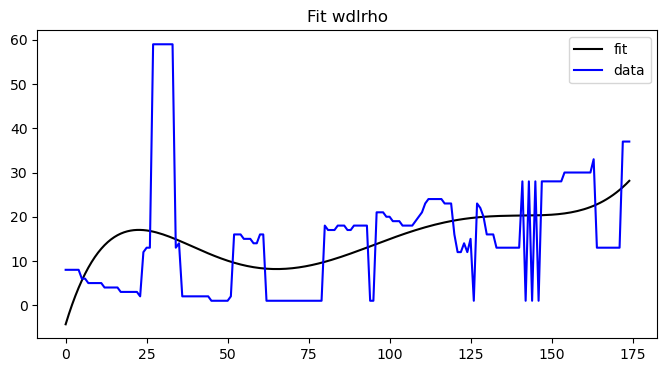

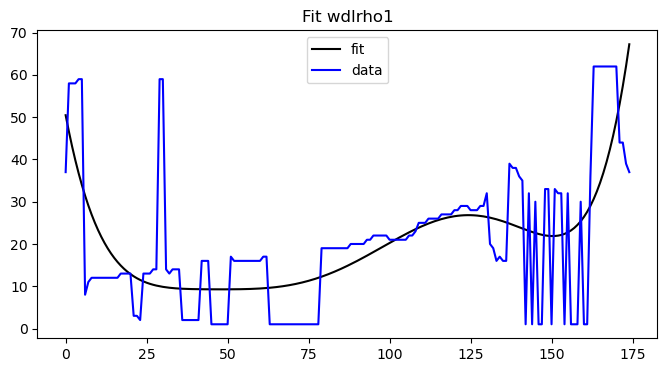

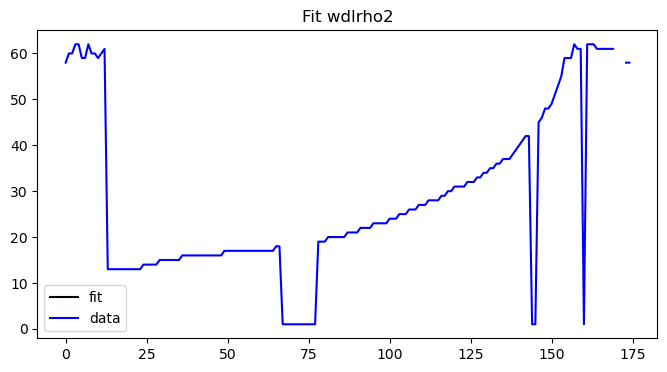

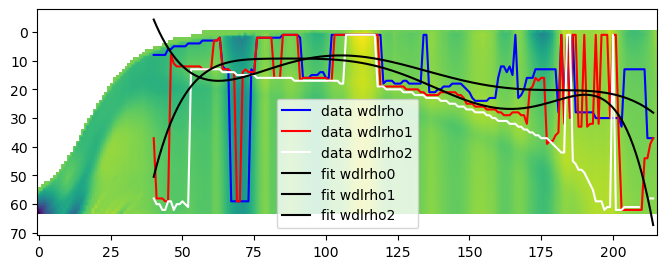

Pos 10
2023_12_04_Ti_pLPT107&pLPT41
t0: 40, tf: 215


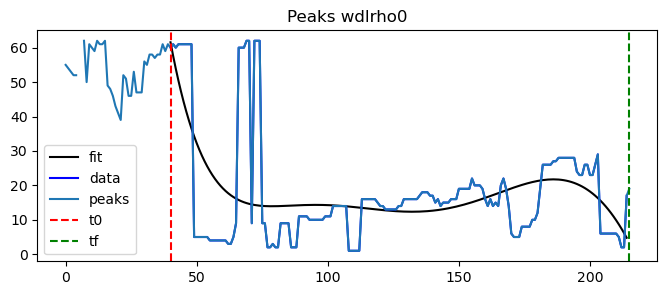

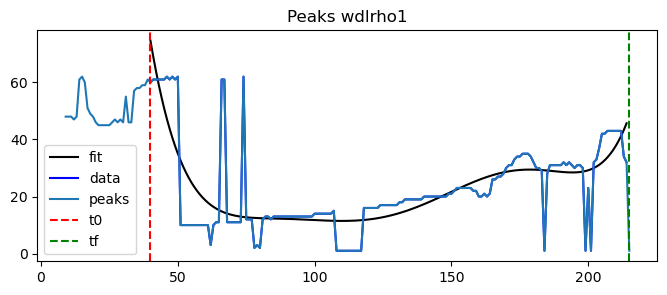

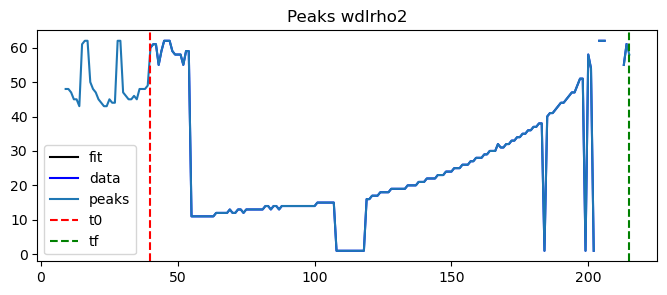

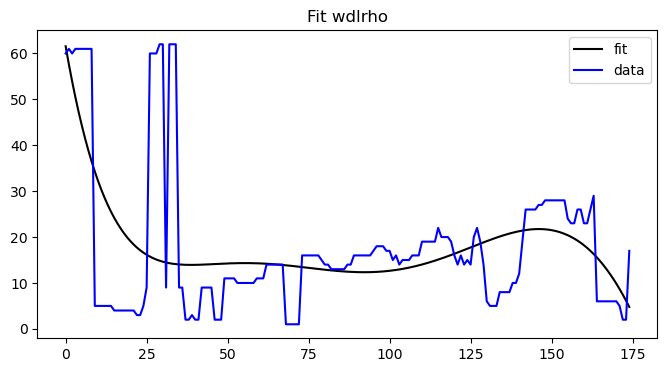

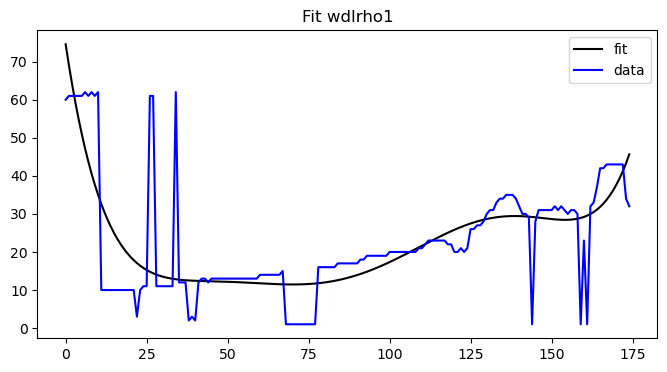

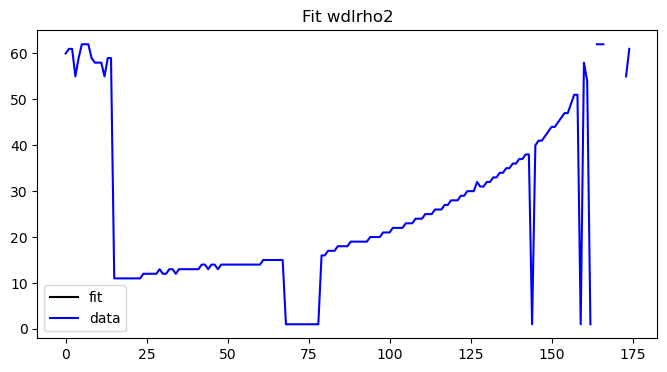

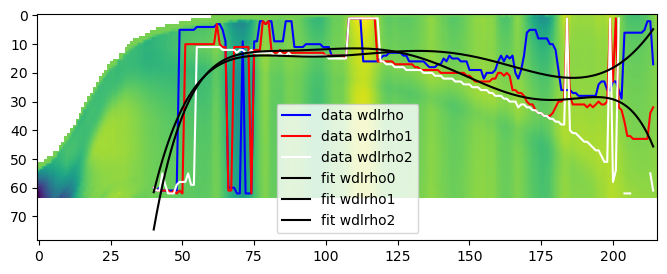

Pos 11
2023_12_04_Ti_pLPT107&pLPT41
t0: 40, tf: 215


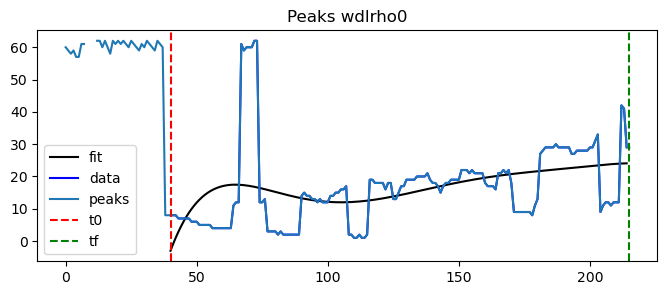

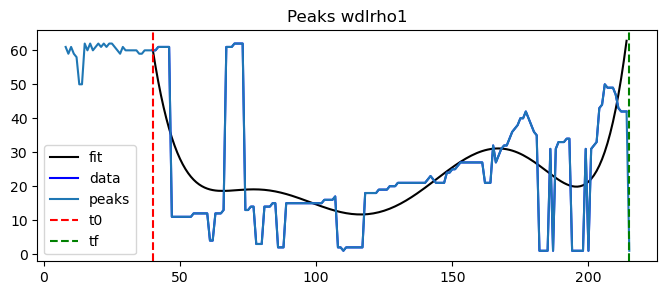

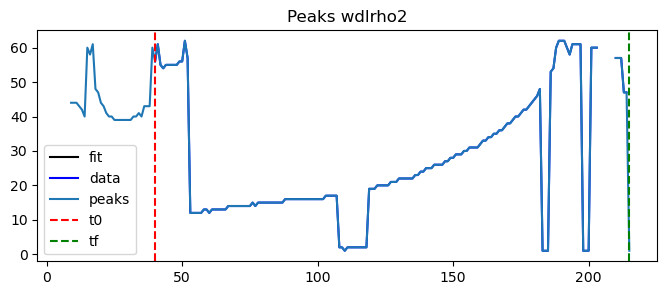

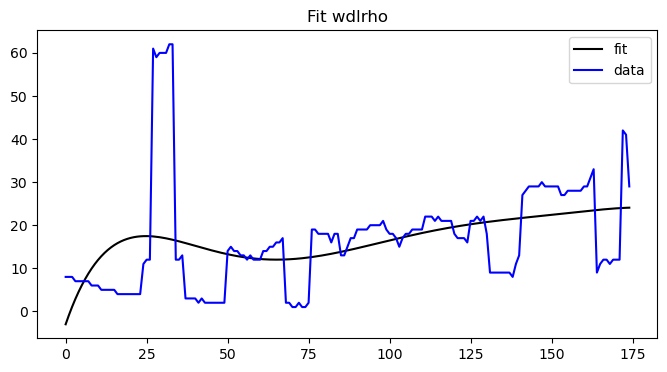

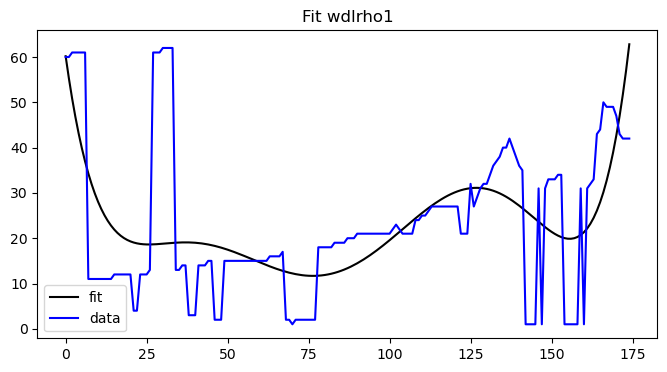

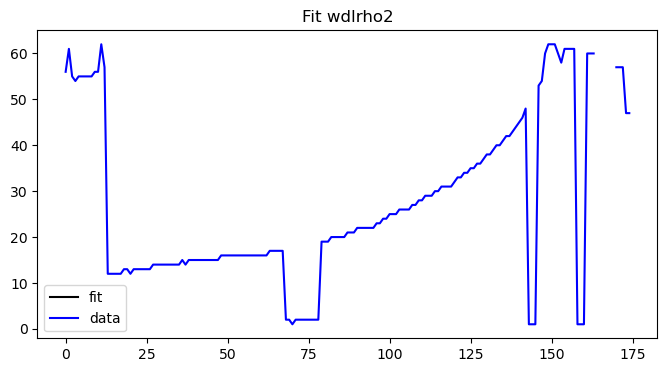

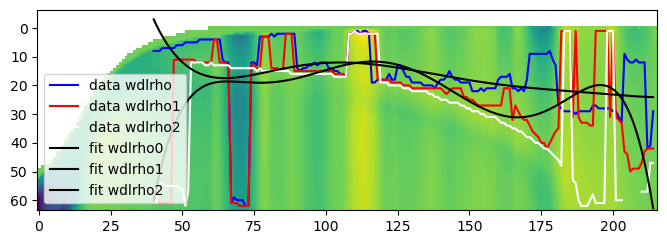

Pos 14
2023_12_04_Ti_pLPT107&pLPT41
t0: 40, tf: 215


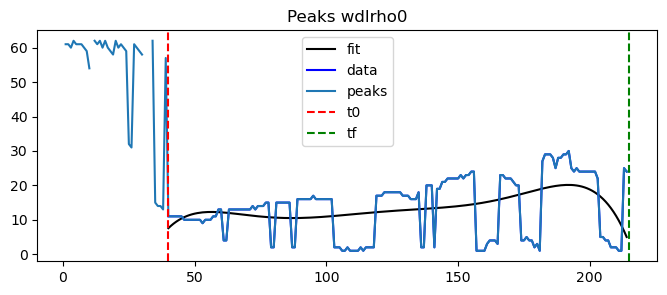

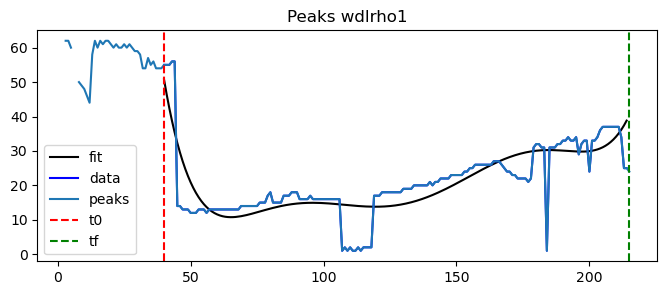

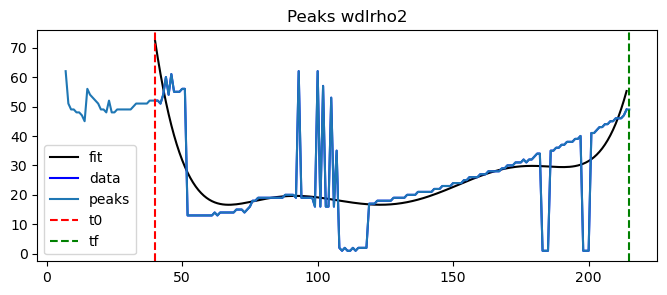

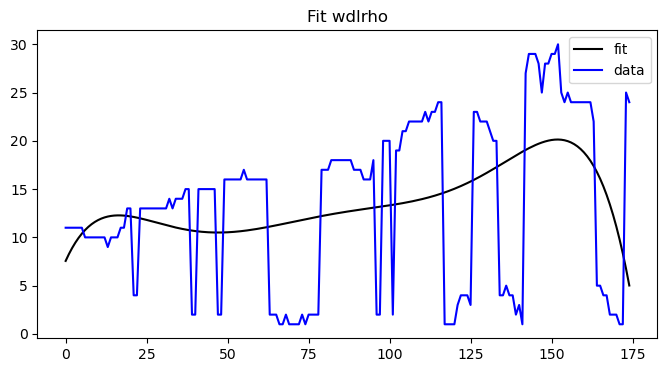

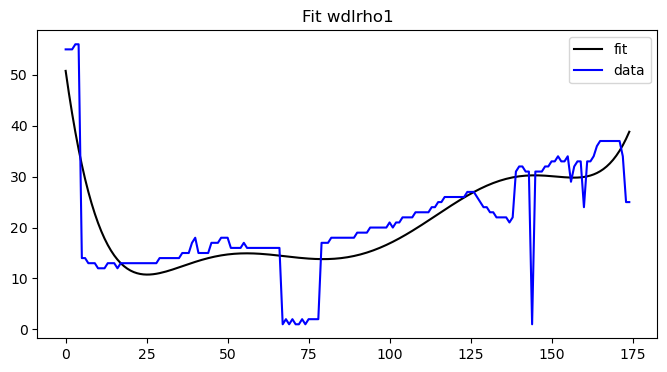

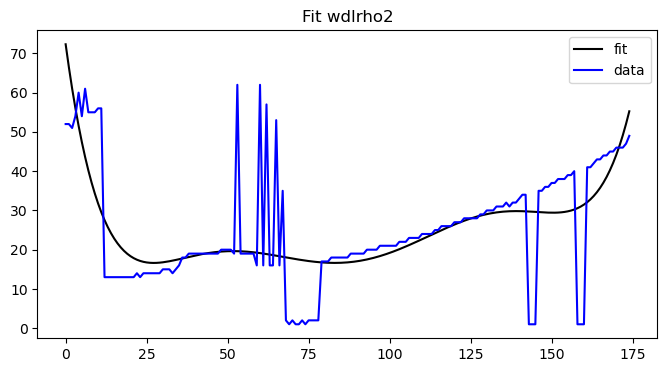

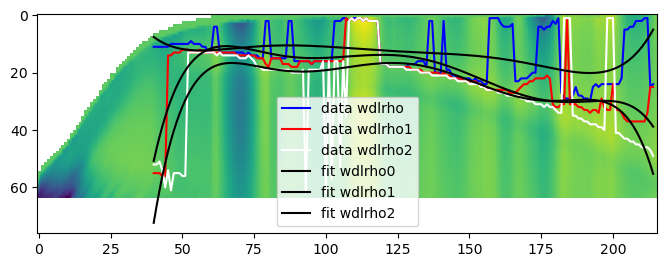

Pos 15
2023_12_04_Ti_pLPT107&pLPT41
t0: 40, tf: 215


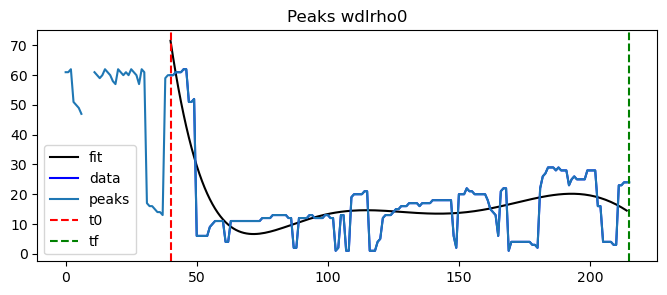

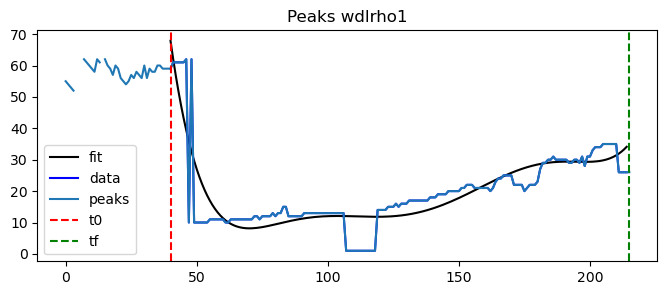

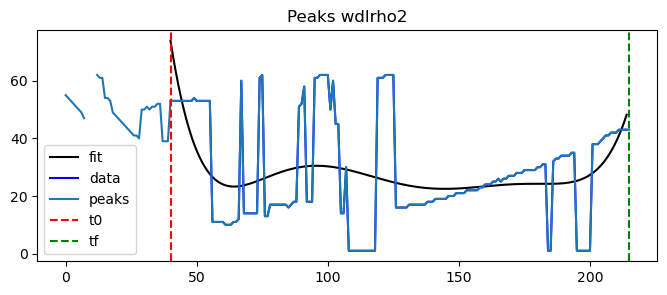

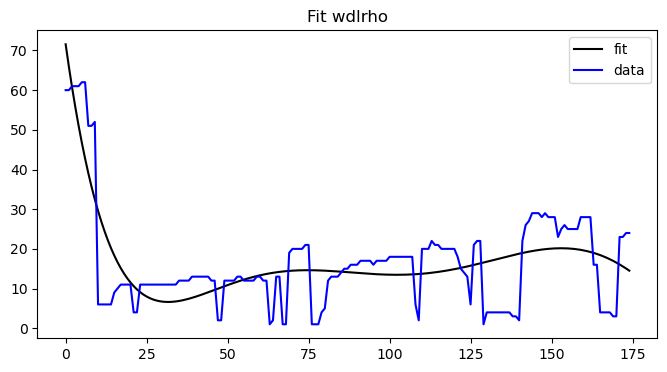

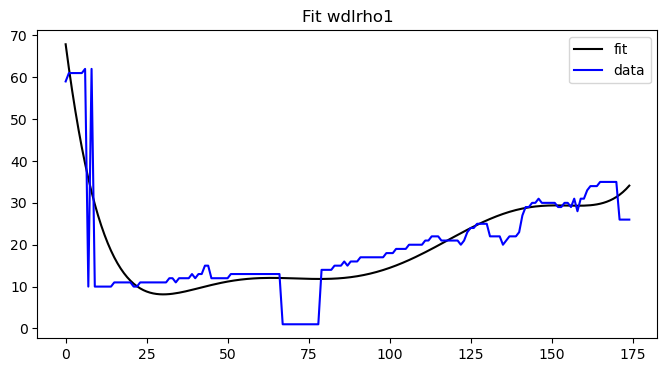

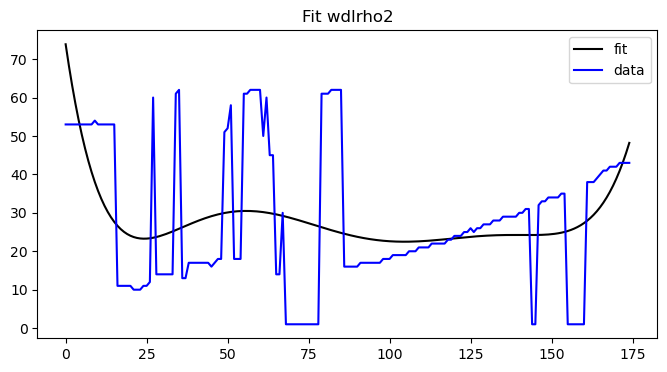

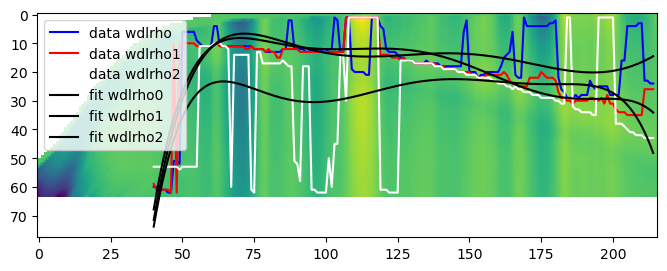

Pos 18
2023_12_04_Ti_pLPT107&pLPT41
t0: 40, tf: 215


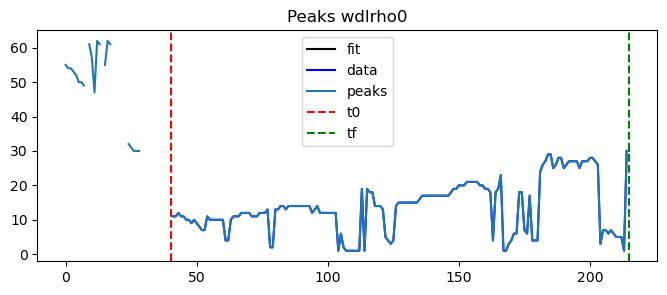

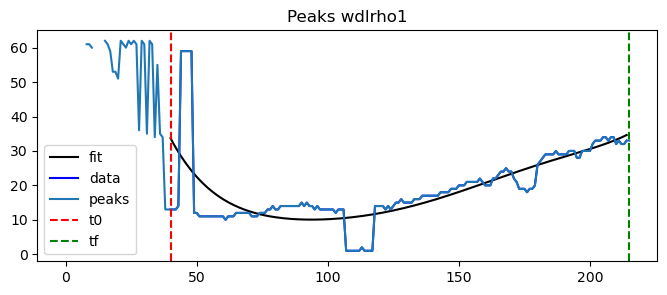

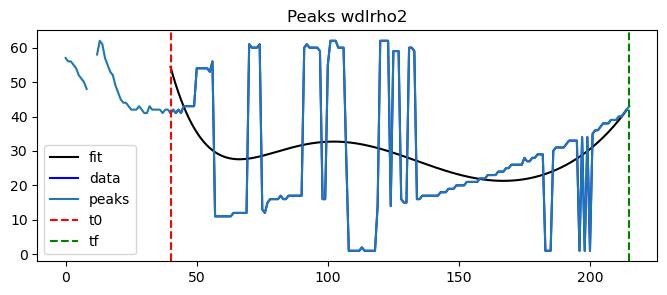

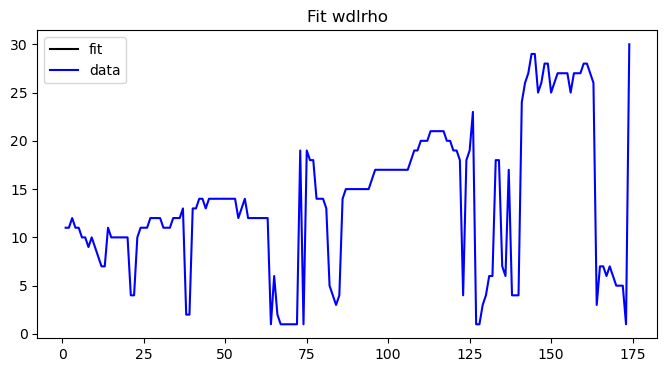

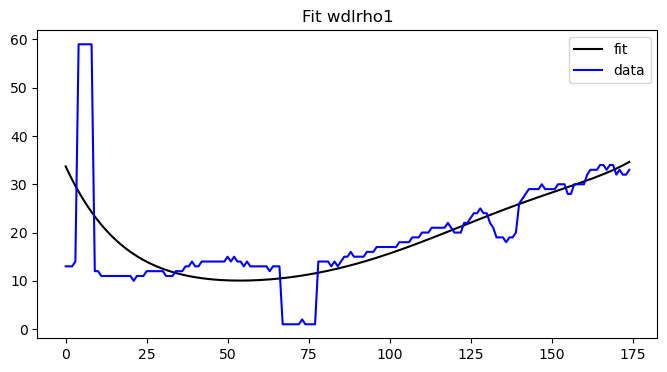

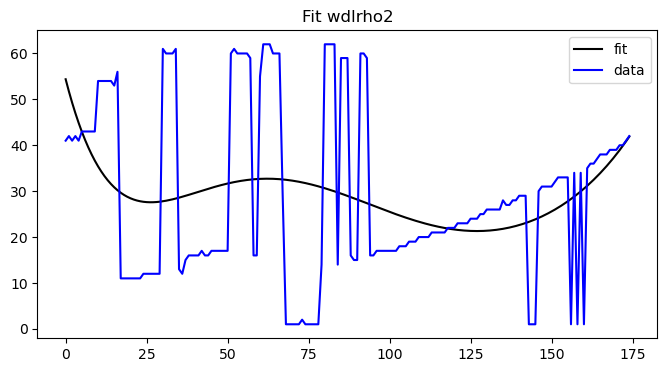

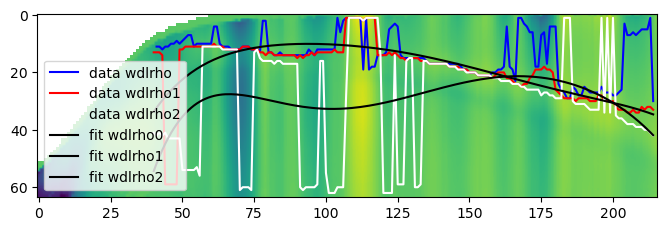

Pos 19
2023_12_04_Ti_pLPT107&pLPT41
t0: 40, tf: 215


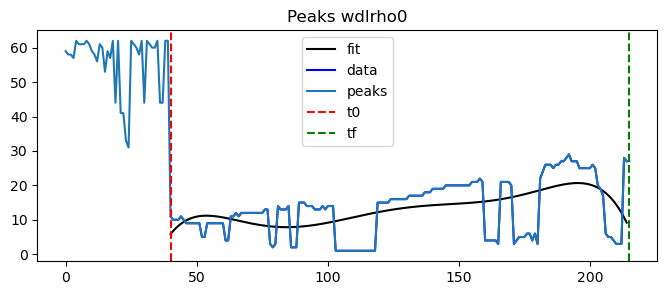

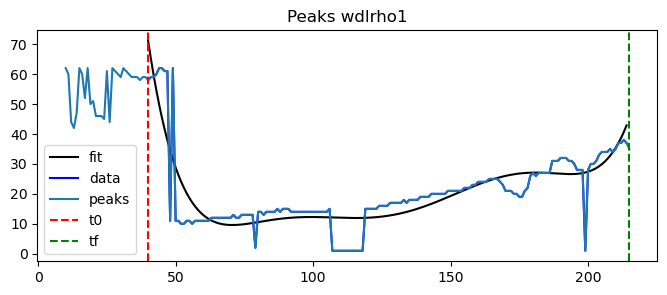

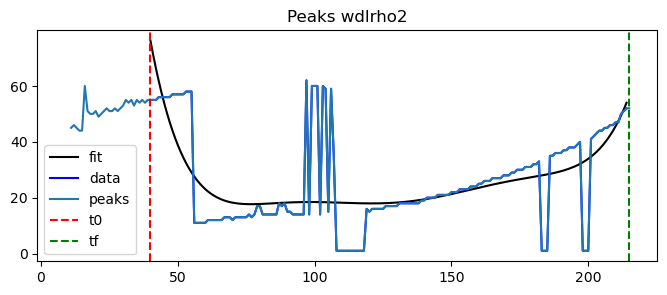

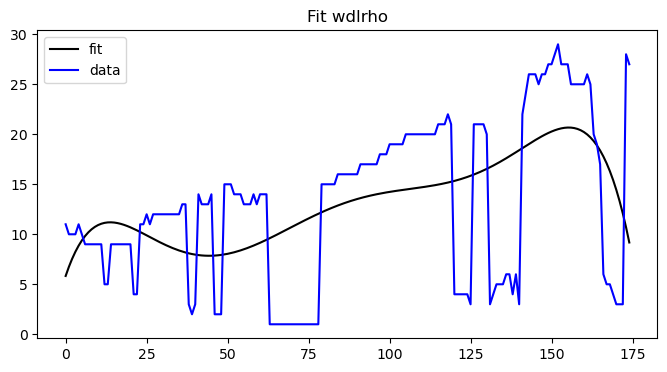

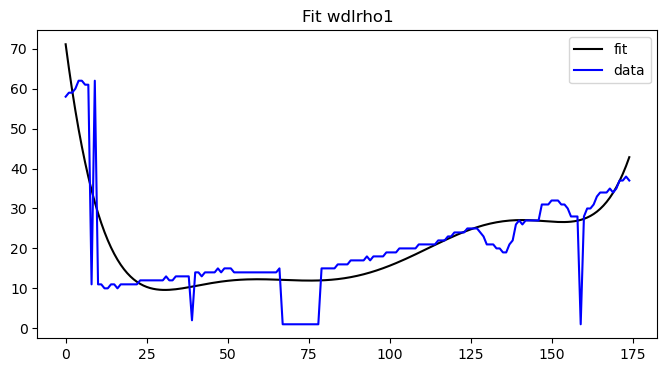

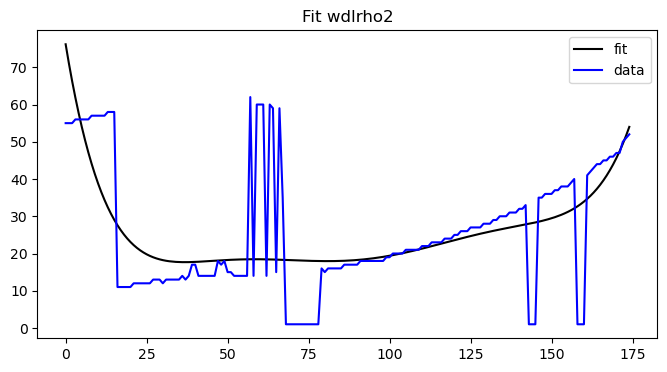

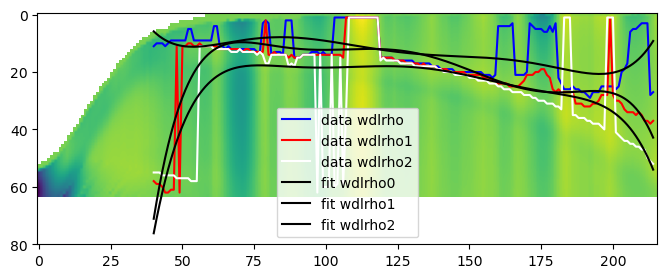

Pos 21
2023_12_04_Ti_pLPT107&pLPT41
t0: 40, tf: 215


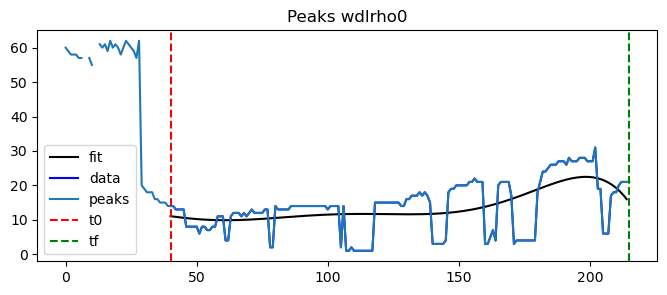

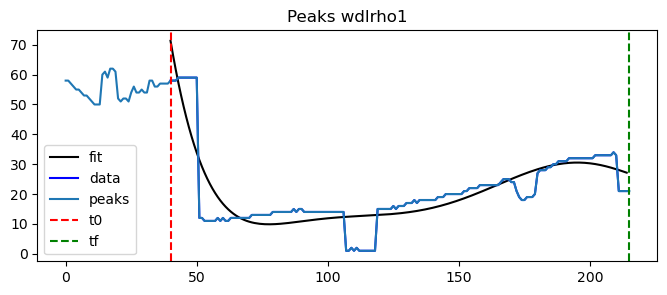

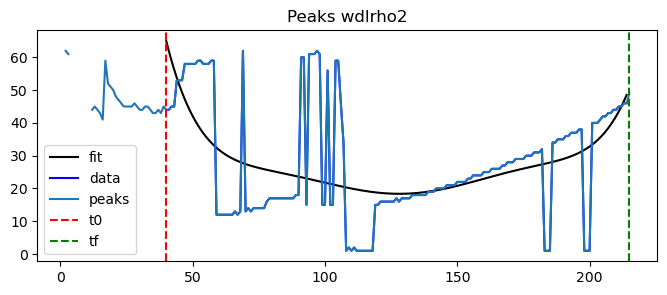

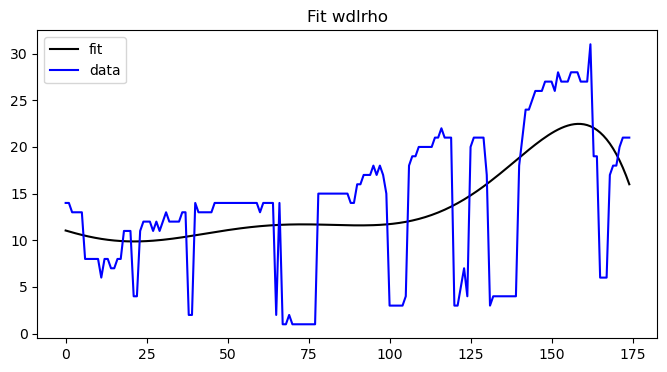

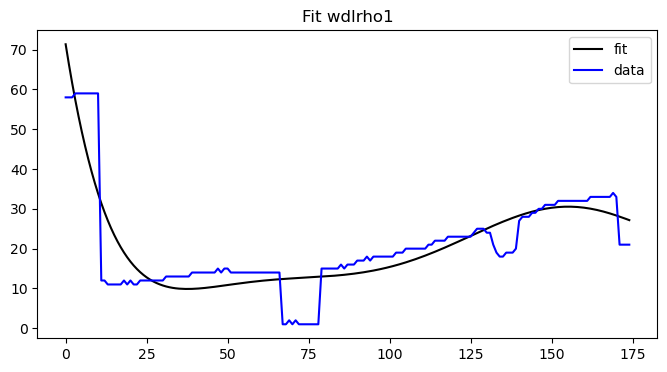

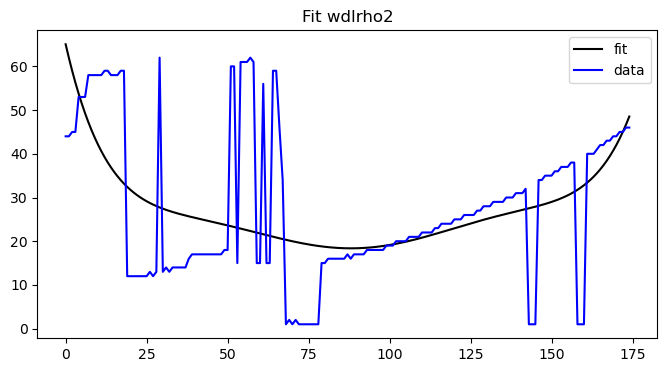

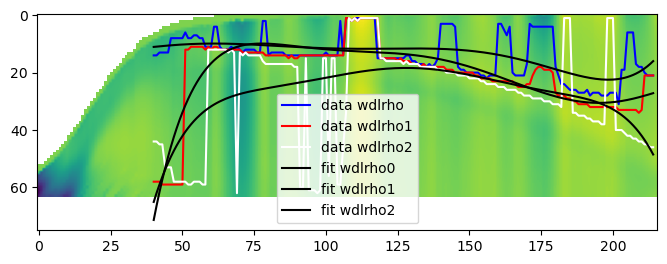

Pos 22
2023_12_04_Ti_pLPT107&pLPT41
t0: 40, tf: 215


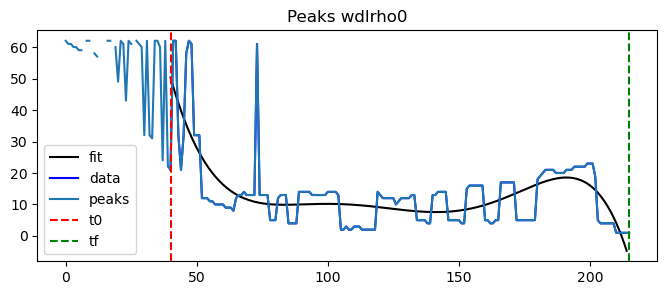

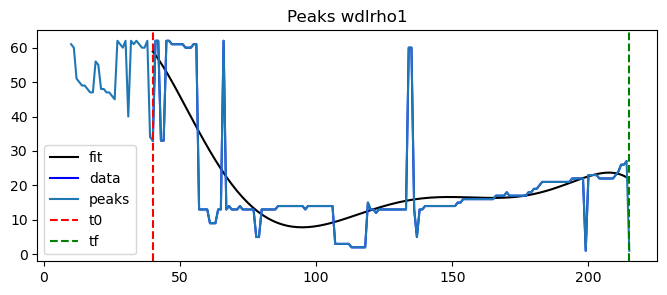

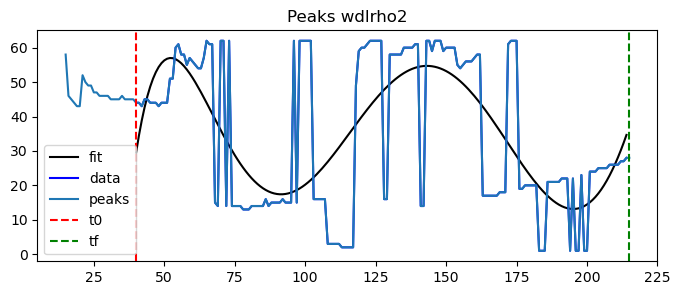

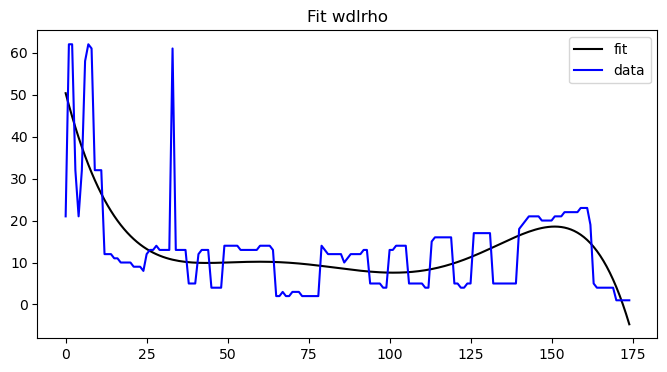

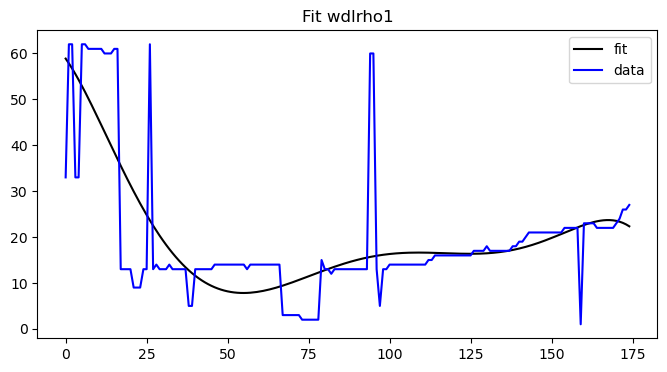

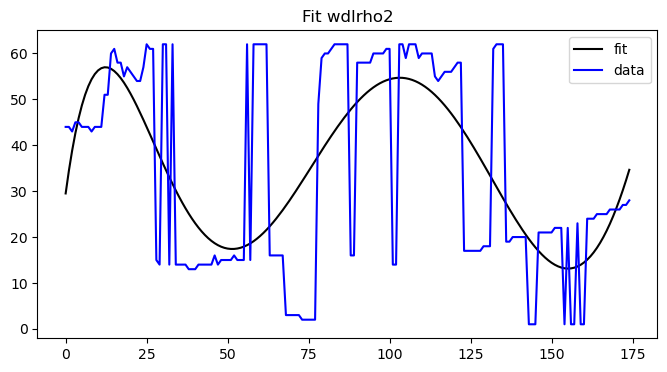

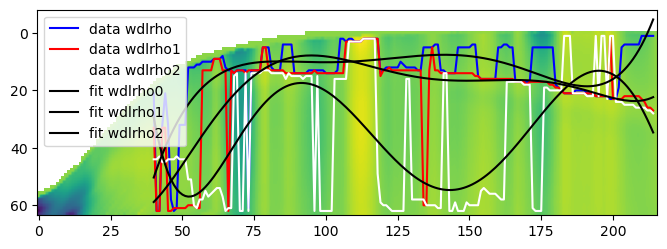

Pos 24
2023_12_04_Ti_pLPT107&pLPT41
t0: 40, tf: 215


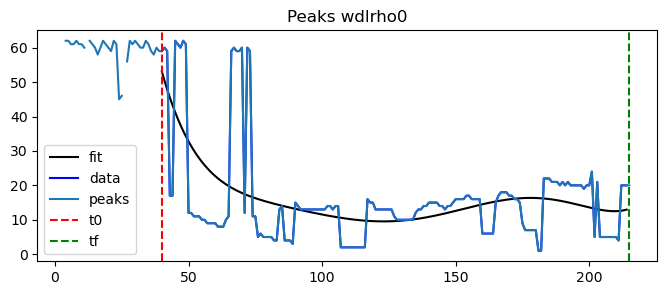

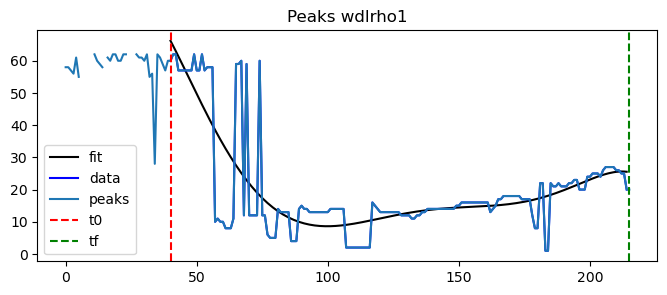

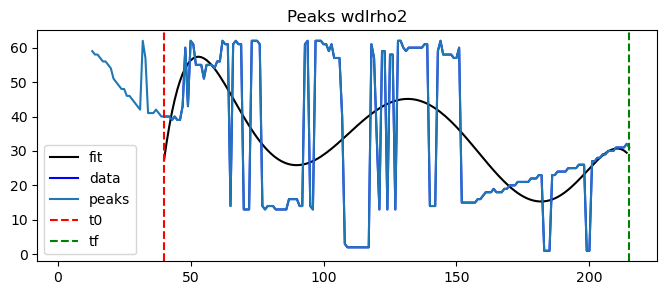

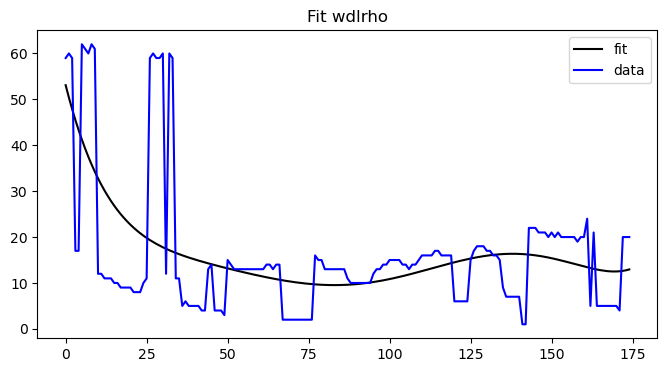

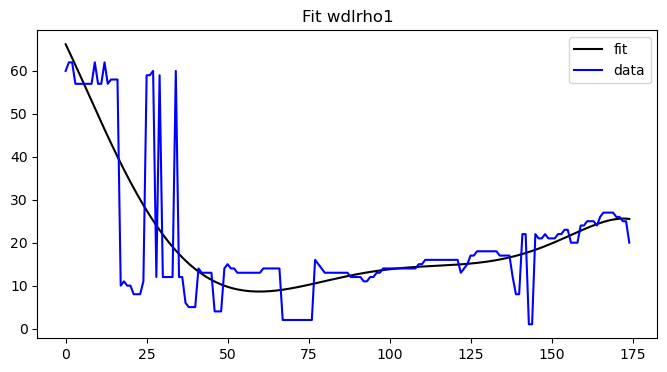

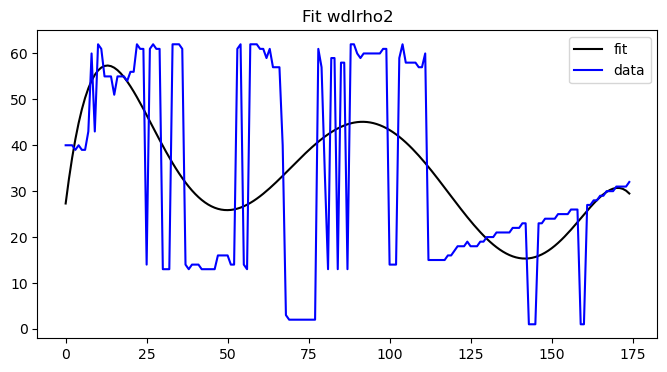

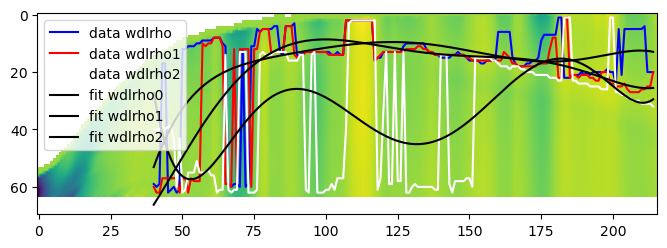

Pos 26
2023_12_04_Ti_pLPT107&pLPT41
t0: 40, tf: 215


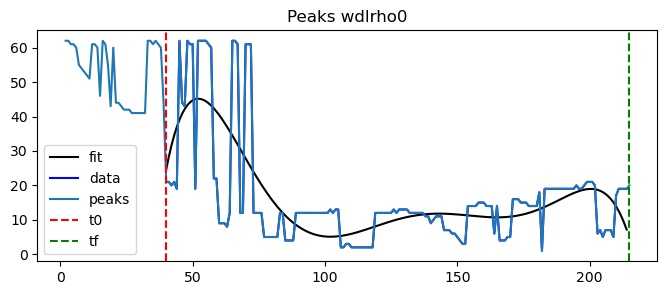

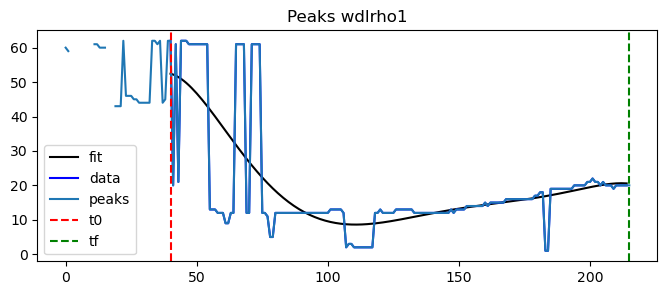

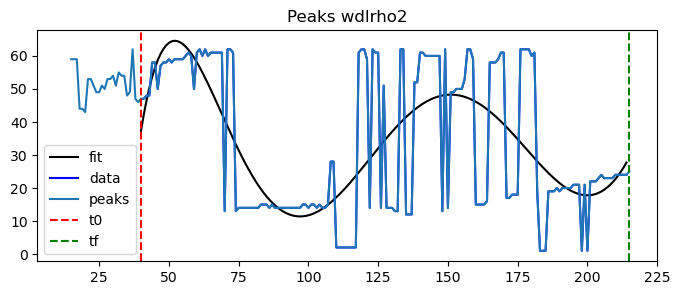

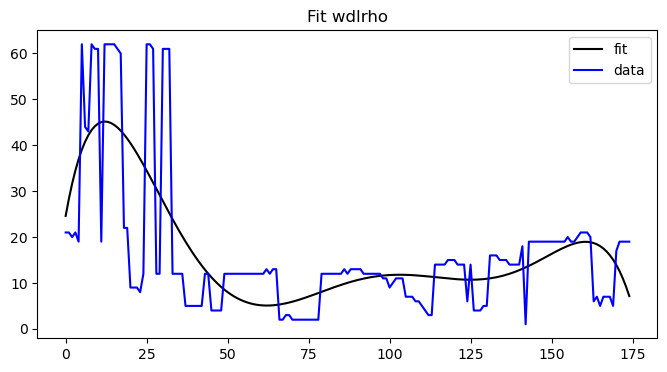

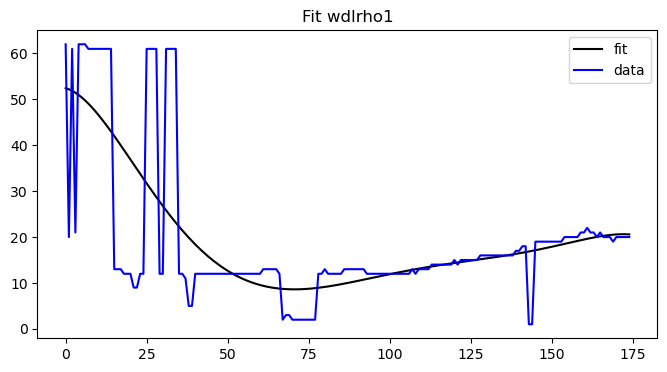

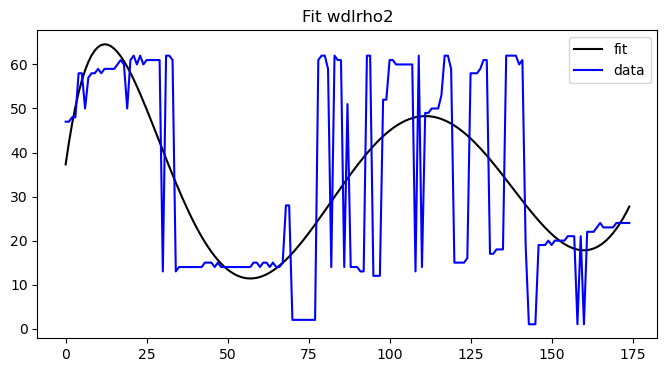

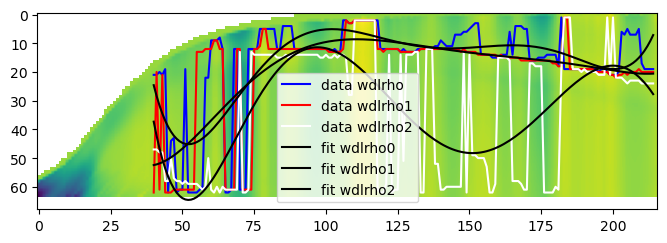

Pos 28
2023_12_04_Ti_pLPT107&pLPT41
t0: 40, tf: 215


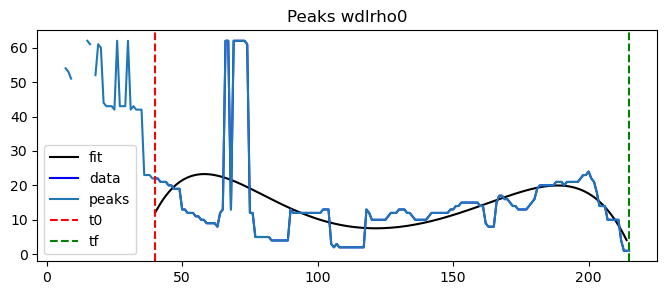

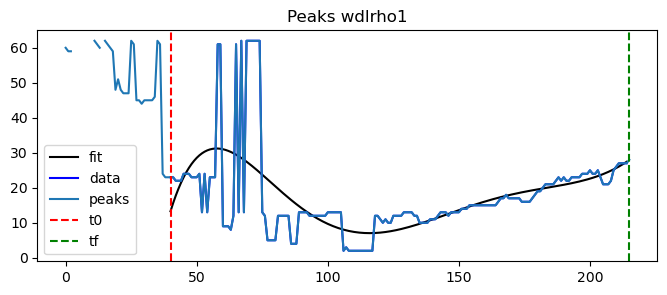

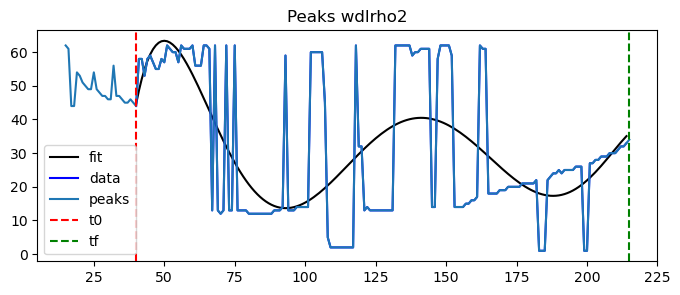

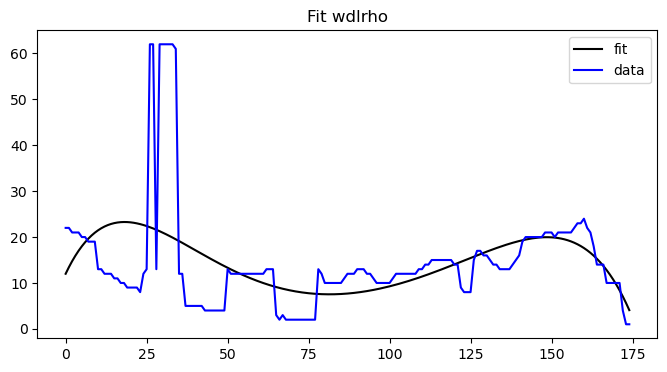

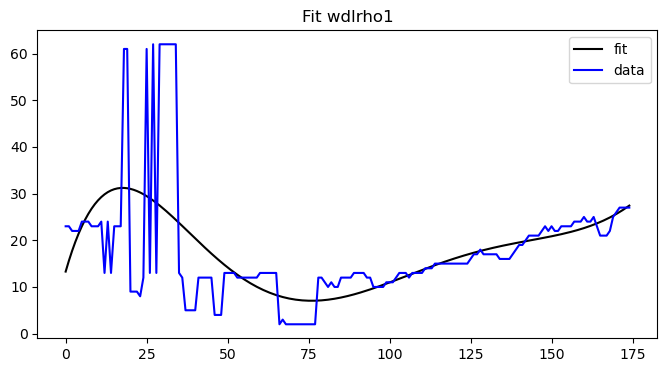

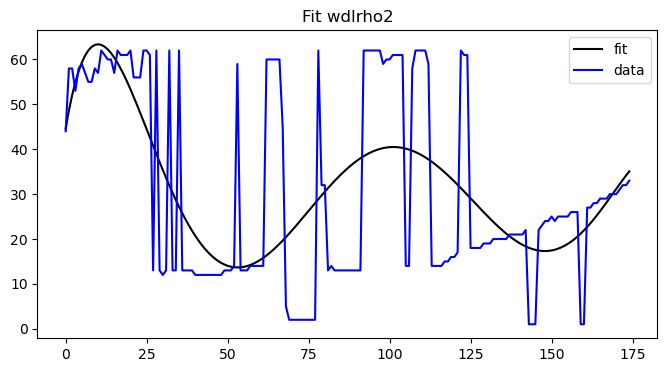

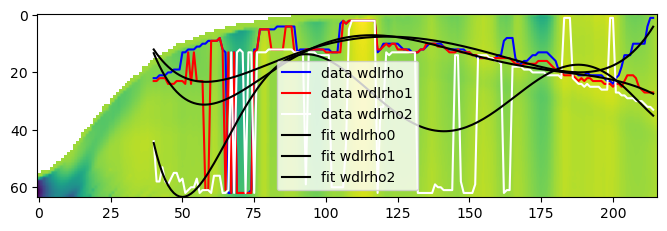

In [900]:
#pdf_file = PdfPages('output_plots.pdf')
#pdf_path = 'output_plots.pdf'
df = pd.read_excel('../Notebooks/data_processed.xlsx')
kymo_bool = False
for i in [8]:#exp_sum.index.values:
    exp_date = exp_sum.loc[i,'formatted_dates']
    vector = exp_sum.loc[i,'DNA']
    scope_name = exp_sum.loc[i,'Machine']
    df_pos = positions[(positions.Date == exp_sum.loc[i, 'Date']) & 
        (positions.DNA == vector) & 
        (positions.Machine == scope_name) & 
        (positions.Quality == 'Very good')]
    poss = df_pos.Position.unique()
    if vector == 'pLPT20&pLPT41' or vector == 'pLPT119&pLPT41':
        yfp_chn = 0
        cfp_chn = 1
        ph_chn = 2
        fluo_chns = 2
    else:
        rfp_chn = 0
        yfp_chn = 1
        cfp_chn = 2
        ph_chn = 3
        fluo_chns = 3
    
    for pos in poss:#[25,28,30,31,32,34,35]:
        print(f"Pos {pos}")
        print(f"{exp_date}_{scopes[scope_name]}_{vector}")
        path_scope = os.path.join(path_ext, scope_name)
        path = os.path.join(path_scope, exp_date)
        path_results = os.path.join(path, folder_results, f"pos{pos}")
        df_idx = df[(df['Date'].dt.strftime('%Y_%m_%d') == exp_date) & 
            (df.Machine == scope_name) & 
            (df.Position == pos)].index[0]
        #if pd.notna(df.loc[df_idx, 'time_wave_start_guess']):
        #t0 = int(df.loc[df_idx, 'time_wave_start_guess'])
        #tf = int(df.loc[df_idx, 'time_wave_arrival_guess'])
        t0 = 40
        tf = 215
        print(f"t0: {t0}, tf: {tf}")

        ## Peaks wdlrho0
        wdlkymo_rho = np.load(os.path.join(path_results,'wdlkymo_rho.npy'))
        nt, nr, _ = wdlkymo_rho.shape
        data = wdlkymo_rho[:,::-1,0].transpose()            
        rads = np.zeros(nt)
        for t in range(nt):
            peaks, _ = find_peaks(data[:,t])
            try:
                idx = np.argsort(data[peaks,t])[-1]
                rads[t] = peaks[idx]
            except:
                rads[t] = np.nan

        ## Peaks wdlrho1
        #wdlkymo_rho = np.load(os.path.join(path_results,'wdlkymo_rho.npy'))
        #nt, nr, _ = wdlkymo_rho.shape
        data1 = wdlkymo_rho[:,::-1,1].transpose()            
        rads1 = np.zeros(nt)
        for t in range(nt):
            peaks1, _ = find_peaks(data1[:,t])
            try:
                idx1 = np.argsort(data1[peaks1,t])[-1]
                rads1[t] = peaks1[idx1]
            except:
                rads1[t] = np.nan

        ## Peaks wdlrho2
        #wdlkymo_rho = np.load(os.path.join(path_results,'wdlkymo_rho.npy'))
        #nt, nr, _ = wdlkymo_rho.shape
        data2 = wdlkymo_rho[:,::-1,2].transpose()            
        rads2 = np.zeros(nt)
        for t in range(nt):
            peaks2, _ = find_peaks(data2[:,t])
            try:
                idx2 = np.argsort(data2[peaks2,t])[-1]
                rads2[t] = peaks2[idx2]
            except:
                rads2[t] = np.nan

        degree = 6

        #rads_or = rads
        #rads = savgol_filter(rads, 21,3)

        ## Fit wdlkymo0
        wave_pos_coefs = np.polyfit(np.arange(len(rads[t0:tf])), rads[t0:tf], degree)
        wave_pos_fit = np.polyval(wave_pos_coefs, np.arange(len(rads[t0:tf])))
        #wave_pos_fit = np.polyval(wave_pos_coefs, np.arange(len(rads[t0:tf])+5))
        
        wave_vel_coefs = np.polyder(wave_pos_coefs)
        wave_vel_fit = np.polyval(wave_vel_coefs, np.arange(len(rads[t0:tf])))
        #with PdfPages(pdf_path) as pdf_file:

        ## Fit wdlkymo0
        wave_pos_coefs1 = np.polyfit(np.arange(len(rads1[t0:tf])), rads1[t0:tf], degree)
        wave_pos_fit1 = np.polyval(wave_pos_coefs1, np.arange(len(rads1[t0:tf])))
        #wave_pos_fit = np.polyval(wave_pos_coefs, np.arange(len(rads[t0:tf])+5))
        
        wave_vel_coefs1 = np.polyder(wave_pos_coefs1)
        wave_vel_fit1 = np.polyval(wave_vel_coefs1, np.arange(len(rads1[t0:tf])))
        #with PdfPages(pdf_path) as pdf_file:

        ## Fit wdlkymo2
        wave_pos_coefs2 = np.polyfit(np.arange(len(rads2[t0:tf])), rads2[t0:tf], degree)
        wave_pos_fit2 = np.polyval(wave_pos_coefs2, np.arange(len(rads2[t0:tf])))
        #wave_pos_fit = np.polyval(wave_pos_coefs, np.arange(len(rads[t0:tf])+5))
        
        wave_vel_coefs2 = np.polyder(wave_pos_coefs2)
        wave_vel_fit2 = np.polyval(wave_vel_coefs2, np.arange(len(rads2[t0:tf])))
        #with PdfPages(pdf_path) as pdf_file:

        ## peaks wdlrho0
        plt.figure(figsize=(8,3))
        plt.plot(np.arange(t0,t0+len(rads[t0:tf])),wave_pos_fit, color='k',label='fit')
        plt.plot(np.arange(t0,t0+len(rads[t0:tf])), rads[t0:tf], color='b', label='data')
        plt.plot(rads, label='peaks')
        plt.axvline(x=t0, color='r', linestyle='--', label='t0')
        plt.axvline(x=tf, color='g', linestyle='--', label='tf')
        plt.title('Peaks wdlrho0')
        plt.legend()
        #pdf_file.savefig() 
        #plt.close()
        plt.show()

        ## peaks wdlrho1
        plt.figure(figsize=(8,3))
        plt.plot(np.arange(t0,t0+len(rads1[t0:tf])),wave_pos_fit1, color='k',label='fit')
        plt.plot(np.arange(t0,t0+len(rads1[t0:tf])), rads1[t0:tf], color='b', label='data')
        plt.plot(rads1, label='peaks')
        plt.axvline(x=t0, color='r', linestyle='--', label='t0')
        plt.axvline(x=tf, color='g', linestyle='--', label='tf')
        plt.title('Peaks wdlrho1')
        plt.legend()
        #pdf_file.savefig() 
        #plt.close()
        plt.show()

        ## peaks wdlrho2
        plt.figure(figsize=(8,3))
        plt.plot(np.arange(t0,t0+len(rads2[t0:tf])),wave_pos_fit2, color='k',label='fit')
        plt.plot(np.arange(t0,t0+len(rads2[t0:tf])), rads2[t0:tf], color='b', label='data')
        plt.plot(rads2, label='peaks')
        plt.axvline(x=t0, color='r', linestyle='--', label='t0')
        plt.axvline(x=tf, color='g', linestyle='--', label='tf')
        plt.title('Peaks wdlrho2')
        plt.legend()
        #pdf_file.savefig() 
        #plt.close()
        plt.show()

        ## fit wdlrho0
        plt.figure(figsize=(8,4))
        plt.plot(np.arange(len(rads[t0:tf])),wave_pos_fit, color='k',label='fit')
        plt.plot(np.arange(len(rads[t0:tf])), rads[t0:tf], color='b', label='data')
        plt.title('Fit wdlrho')
        plt.legend()
        #pdf_file.savefig() 
        #plt.close()
        plt.show()

        ## fit wdlrho1
        plt.figure(figsize=(8,4))
        plt.plot(np.arange(len(rads1[t0:tf])),wave_pos_fit1, color='k',label='fit')
        plt.plot(np.arange(len(rads1[t0:tf])), rads1[t0:tf], color='b', label='data')
        plt.title('Fit wdlrho1')
        plt.legend()
        #pdf_file.savefig() 
        #plt.close()
        plt.show()

        ## fit wdlrho2
        plt.figure(figsize=(8,4))
        plt.plot(np.arange(len(rads2[t0:tf])),wave_pos_fit2, color='k',label='fit')
        plt.plot(np.arange(len(rads2[t0:tf])), rads2[t0:tf], color='b', label='data')
        plt.title('Fit wdlrho2')
        plt.legend()
        #pdf_file.savefig() 
        #plt.close()
        plt.show()

        ## All
        plt.figure(figsize=(8,4))
        
        plt.imshow(data2)
        plt.plot(np.arange(t0,tf), rads[t0:tf], color='b', label='data wdlrho')
        plt.plot(np.arange(t0,tf), rads1[t0:tf], color='r', label='data wdlrho1')
        plt.plot(np.arange(t0,tf), rads2[t0:tf], color='w', label='data wdlrho2')
        plt.plot(np.arange(t0,tf),wave_pos_fit, color='k',label='fit wdlrho0')
        plt.plot(np.arange(t0,tf),wave_pos_fit1, color='k',label='fit wdlrho1')
        plt.plot(np.arange(t0,tf),wave_pos_fit2, color='k',label='fit wdlrho2')
        plt.legend()
        #pdf_file.savefig() 
        #plt.close()
        plt.show()
                    

[12. 13. 14. 16. 16. 16. 16. 16. 16. 17. 17. 17. 17. 17. 17. 17. 17. 18.
 16. 19. 19. 18. 18. 18. 19. 18. 18. 18. 18. 17. 18. 19. 18. 18. 19. 20.
 20. 20. 20. 20. 20. 20. 21. 21. 22. 23. 23. 23. 24. 24. 25. 25. 26. 26.
 26. 26. 27. 27. 28. 29. 30. 31. 31. 31. 33. 34. 35. 36. 37. 40. 41. 41.
 42. 44. 46. 46. 48. 49. 50.]


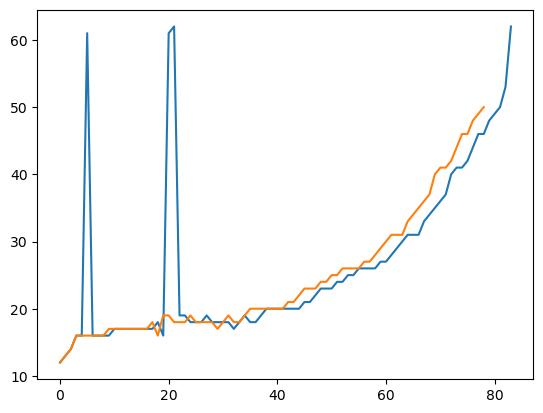

In [562]:
plt.plot(rads2[t0:tf])
data = rads2[t0:tf]
mean = np.mean(data)
std = np.std(data)

# Define a threshold for identifying outliers
num_std_dev = 2  # You can adjust this value to be more or less strict

# Identify and remove the peaks (outliers)
filtered_data = data[np.abs(data - mean) < num_std_dev * std]

print(filtered_data)
plt.plot(filtered_data)

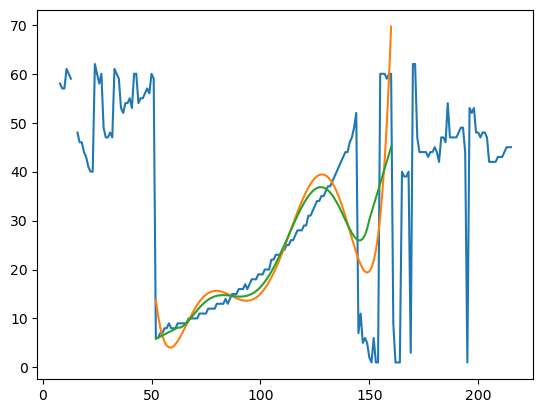

In [543]:
plt.plot(rads2)
plt.plot(np.arange(t0,tf),wave_pos_fit2)
plt.plot(np.arange(t0,tf),savgol_filter(wave_pos_fit2,21,1))

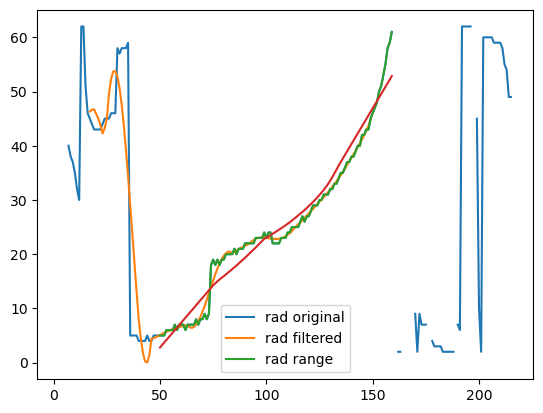

In [114]:
plt.plot(rads_or, label='rad original')
plt.plot(rads, label='rad filtered')
plt.plot(np.arange(t0,tf),rads_or[t0:tf], label='rad range')
plt.plot(np.arange(t0,tf),savgol_filter(rads_or[t0:tf],31,1))
plt.legend()

In [43]:
plt.plot(np.arange(t0,t0+len(rads[t0:tf])+5),wave_pos_fit, color='k',label='fit')

In [11]:
len(np.arange(t0,t0+len(rads[t0:tf])+5))

90

In [37]:
wave_pos_coefs

array([ 1.45010237e-09, -4.86646867e-07,  6.36547618e-05, -4.01304865e-03,
        1.22479211e-01, -1.25618757e+00,  1.54187158e+01])

In [17]:
degree = 3
wave_pos_coefs = np.polyfit(np.arange(len(rads[t0:tf])), rads[t0:tf], degree)
wave_pos_fit = np.polyval(wave_pos_coefs, np.arange(len(rads[t0:tf])))

wave_vel_coefs = np.polyder(wave_pos_coefs)
wave_vel_fit = np.polyval(wave_vel_coefs, np.arange(len(rads[t0:tf])))

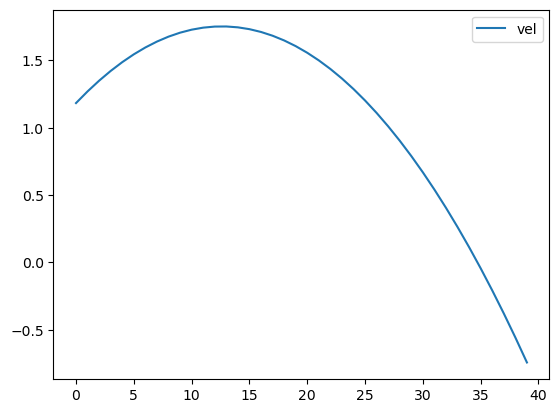

In [18]:
#plt.plot(wave_pos_fit, label='pos')
plt.plot(wave_vel_fit, label='vel')
plt.legend()
plt.show()

In [362]:
exp_sum = pd.read_excel('../Notebooks/Exps_summary.xlsx')
exp_sum['formatted_dates'] = exp_sum['Date'].dt.strftime('%Y_%m_%d')
positions = pd.read_excel('../Notebooks/Positions.xlsx')
exp_sum

Date      Machine           Strain             DNA Chemical Dilution  \
0  2023-11-15     Ti scope  MC4100 & DHL708   pLPT20&pLPT41        -  10^(-5)   
1  2023-11-15  Tweez scope  MC4100 & DHL708   pLPT20&pLPT41        -  10^(-6)   
2  2023-11-17     Ti scope           DHL708  pLPT119&pLPT41        -  10^(-5)   
3  2023-11-17  Tweez scope  MC4100 & DHL708  pLPT119&pLPT41        -  10^(-6)   
4  2023-11-28     Ti scope  MC4100 & MG1655            pAAA        -  10^(-6)   
5  2023-11-28  Tweez scope           MG1655            pAAA        -  10^(-5)   
6  2023-11-30     Ti scope           MC4100            pAAA        -  10^(-6)   
7  2023-11-30  Tweez scope           MC4100            pAAA        -  10^(-5)   
8  2023-12-04     Ti scope           MC4100  pLPT107&pLPT41     IPTG  10^(-6)   
9  2023-12-04  Tweez scope           MC4100  pLPT107&pLPT41     IPTG  10^(-5)   
10 2023-12-06  Tweez scope           MC4100   pLPT20&pLPT41     IPTG  10^(-5)   
11 2023-12-08     Ti scope           MC4100  pLPT107&pLPT41      aTc  10^(-5)   
12 2023-12-08  Tweez scope           MC4100   pLPT20&pLPT41      aTc  10^(-5)   

   formatted_dates  
0       2023_11_15  
1       2023_11_15  
2       2023_11_17  
3       2023_11_17  
4       2023_11_28  
5       2023_11_28  
6       2023_11_30  
7       2023_11_30  
8       2023_12_04  
9       2023_12_04  
10      2023_12_06  
11      2023_12_08  
12      2023_12_08

In [363]:
path_results

'/media/guillermo/Expansion/Thesis GY/3. Analyzed files/Tweez scope/2023_12_08/results/pos38'

In [478]:
i=10

In [479]:
df_pos = positions[(positions.Date == exp_sum.loc[i, 'Date']) & 
        (positions.DNA == vector) & 
        (positions.Machine == scope_name) & 
        (positions.Quality == 'Very good')]
poss = df_pos.Position.unique()

In [480]:
poss

array([], dtype=int64)

In [ ]:
dlkymo_rho = np.load(os.path.join(path_results, 'dlkymo_rho.npy'))
edt = np.load(os.path.join(path_results, 'edt.npy'))
nr = 64
rw = 16
rs = np.linspace(rw, edt.max(), nr)
t0kymo = 0
plot_dlrho(dlkymo_rho, edt, rs, pos, fluo_chns,t0kymo)

Pos 11
2023_12_06_TiTweez_pLPT20&pLPT41


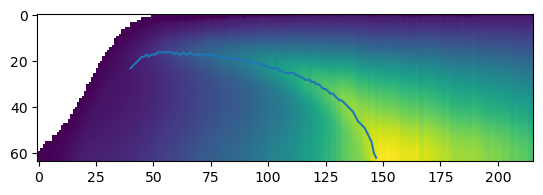

In [485]:
for i in [10]:#exp_sum.index.values:
    exp_date = exp_sum.loc[i,'formatted_dates']
    vector = exp_sum.loc[i,'DNA']
    scope_name = exp_sum.loc[i,'Machine']
    df_pos = positions[(positions.Date == exp_sum.loc[i, 'Date']) & 
        (positions.DNA == vector) & 
        (positions.Machine == scope_name) & 
        (positions.Quality == 'Very good')]
    poss = df_pos.Position.unique()
    if vector == 'pLPT20&pLPT41' or vector == 'pLPT119&pLPT41':
        yfp_chn = 0
        cfp_chn = 1
        ph_chn = 2
        fluo_chns = 2
    else:
        rfp_chn = 0
        yfp_chn = 1
        cfp_chn = 2
        ph_chn = 3
        fluo_chns = 3
    
    for pos in [11]:#poss:
        print(f"Pos {pos}")
        print(f"{exp_date}_{scopes[scope_name]}_{vector}")
        path_scope = os.path.join(path_ext, scope_name)
        path = os.path.join(path_scope, exp_date)
        path_results = os.path.join(path, folder_results, f"pos{pos}")
        df_idx = df[(df['Date'].dt.strftime('%Y_%m_%d') == exp_date) & 
            (df.Machine == scope_name) & 
            (df.Position == pos)].index[0]
        
        #kymo = np.load(os.path.join(path_results, 'kymo.npy'))
        #edt = np.load(os.path.join(path_results, 'edt.npy'))
        
    
        nr = 64
        rw = 16
        rs = np.linspace(rw, edt.max(), nr)
        if fluo_chns == 3:
            wkymo = np.zeros_like(kymo)
            nt, _, nc = wkymo.shape
            
            for c in range(nc):
                wkymo[:,:,c] = warp(kymo[:,:,c], map_edt, {'edt':edt, 'rs':rs})
            wkymo[np.isnan(kymo)] = np.nan
            
            data = wkymo[:,::-1,2].transpose()
            plt.imshow(data)
        if fluo_chns == 2:
            #wkymo = np.zeros_like(kymo)
            nt, _, nc = wkymo.shape
            
            #for c in range(nc):
            #wkymo = warp(kymo, map_edt, {'edt':edt, 'rs':rs})
            #wkymo[np.isnan(kymo)] = np.nan
            
            data = wkymo[:,::-1,1].transpose()
            plt.imshow(data)
        rads = np.zeros(nt)         
        for t in range(nt):
            peaks, _ = find_peaks(data[:,t])
            try:
                idx = np.argsort(data[peaks,t])[-1]
                rads[t] = peaks[idx]
            except:
                rads[t] = np.nan
        plt.plot(rads)
        plt.show()

In [486]:
rads

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, 23., 22., 21., 20., 19., 18., 18., 17., 18., 17., 17., 17.,
       16., 16., 16., 16., 16., 16., 16., 17., 16., 17., 17., 16., 17.,
       17., 16., 17., 17., 17., 17., 17., 17., 17., 17., 17., 18., 17.,
       18., 18., 18., 19., 18., 19., 18., 19., 19., 19., 19., 20., 20.,
       20., 20., 20., 21., 21., 21., 21., 22., 22., 22., 23., 23., 23.,
       23., 24., 24., 25., 25., 25., 25., 25., 26., 26., 27., 27., 28.,
       28., 28., 29., 29., 30., 30., 31., 32., 32., 33., 34., 34., 35.,
       36., 37., 37., 38., 39., 40., 41., 42., 44., 46., 47., 48., 49.,
       51., 53., 55., 60., 62., nan, 62., nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [487]:
wdlkymo_rho = np.load(os.path.join(path_results, 'wdlkymo_rho.npy'))


In [ ]:
plt.imshow(np.hstack([wdlkymo_rho[t0:,::-1,0],wdlkymo_rho[t0:,:,0]]).transpose(), 
            aspect='auto', 
            extent=[t0,nt,-edt.max(),edt.max()],
            vmin=-0.1, vmax=0.1,
            cmap='jet')

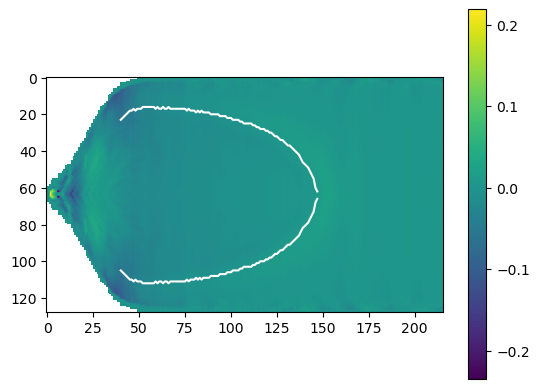

In [523]:
data = np.hstack([wdlkymo_rho[:,::-1],wdlkymo_rho[:,:]]).transpose()
sy, _ = data.shape
plt.imshow(data)
plt.plot(rads,'w')
plt.plot(-rads+sy,'w')
plt.colorbar()
plt.show()

In [521]:
data.shape

(128, 216)

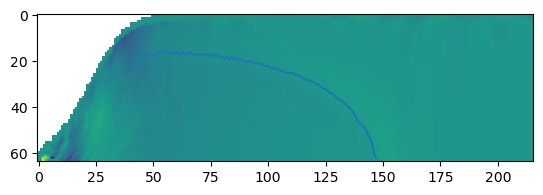

In [511]:
data = wdlkymo_rho[:,::-1].transpose()
plt.imshow(data)
plt.plot(rads)
plt.show()

In [524]:
rads

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, 23., 22., 21., 20., 19., 18., 18., 17., 18., 17., 17., 17.,
       16., 16., 16., 16., 16., 16., 16., 17., 16., 17., 17., 16., 17.,
       17., 16., 17., 17., 17., 17., 17., 17., 17., 17., 17., 18., 17.,
       18., 18., 18., 19., 18., 19., 18., 19., 19., 19., 19., 20., 20.,
       20., 20., 20., 21., 21., 21., 21., 22., 22., 22., 23., 23., 23.,
       23., 24., 24., 25., 25., 25., 25., 25., 26., 26., 27., 27., 28.,
       28., 28., 29., 29., 30., 30., 31., 32., 32., 33., 34., 34., 35.,
       36., 37., 37., 38., 39., 40., 41., 42., 44., 46., 47., 48., 49.,
       51., 53., 55., 60., 62., nan, 62., nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

(0.0, 216.0)

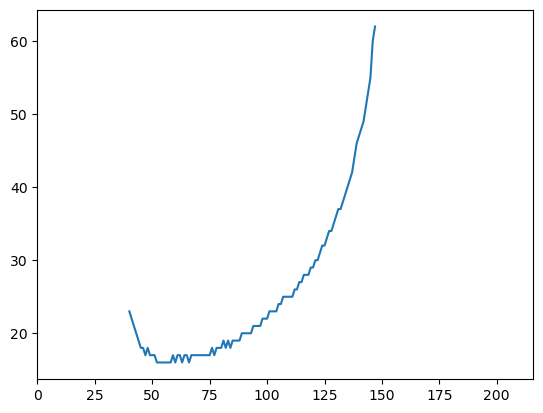

In [529]:
nt = rads.shape[0]
plt.plot(rads)
plt.xlim([0, nt])

In [536]:
degree = 2
idx = ~np.isnan(rads)
trad = np.arange(0,nt)
pos_coefs = np.polyfit(trad[idx], rads[idx], degree)
pos_fit = np.polyval(pos_coefs,trad[idx])

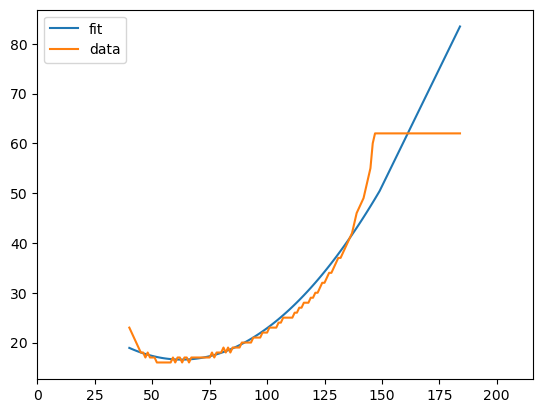

In [549]:
plt.plot(trad[idx], pos_fit, label='fit')
plt.plot(trad[idx],rads[idx], label='data')
plt.xlim([0, nt])
plt.legend()
plt.show()

In [547]:
trad[idx]

array([ 40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 149, 184])

In [550]:
rads

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, 23., 22., 21., 20., 19., 18., 18., 17., 18., 17., 17., 17.,
       16., 16., 16., 16., 16., 16., 16., 17., 16., 17., 17., 16., 17.,
       17., 16., 17., 17., 17., 17., 17., 17., 17., 17., 17., 18., 17.,
       18., 18., 18., 19., 18., 19., 18., 19., 19., 19., 19., 20., 20.,
       20., 20., 20., 21., 21., 21., 21., 22., 22., 22., 23., 23., 23.,
       23., 24., 24., 25., 25., 25., 25., 25., 26., 26., 27., 27., 28.,
       28., 28., 29., 29., 30., 30., 31., 32., 32., 33., 34., 34., 35.,
       36., 37., 37., 38., 39., 40., 41., 42., 44., 46., 47., 48., 49.,
       51., 53., 55., 60., 62., nan, 62., nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [545]:
rads.shape

(216,)

In [546]:
rads[idx].shape

(110,)